##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# How to solve a problem on Kaggle with TF-Hub


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub_on_kaggle"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/nnlm-en-dim128/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

TF-Hub is a platform to share machine learning expertise packaged in reusable resources, notably pre-trained **modules**. In this tutorial, we will use a TF-Hub text embedding module to train a simple sentiment classifier with a reasonable baseline accuracy. We will then submit the predictions to Kaggle.

For more detailed tutorial on text classification with TF-Hub and further steps for improving the accuracy, take a look at [Text classification with TF-Hub](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/text_classification_with_tf_hub.ipynb).

## Setup

In [2]:
!pip install -q kaggle

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

from sklearn import model_selection

Since this tutorial will be using a dataset from Kaggle, it requires [creating an API Token](https://github.com/Kaggle/kaggle-api) for your Kaggle account, and uploading it to the Colab environment.

In [4]:
import os
import pathlib

# Upload the API token.
def get_kaggle():
  try:
    import kaggle
    return kaggle
  except OSError:
    pass

  token_file = pathlib.Path("~/.kaggle/kaggle.json").expanduser()
  token_file.parent.mkdir(exist_ok=True, parents=True)

  try:
    from google.colab import files
  except ImportError:
    raise ValueError("Could not find kaggle token.")

  uploaded = files.upload()
  token_content = uploaded.get('kaggle.json', None)
  if token_content:
    token_file.write_bytes(token_content)
    token_file.chmod(0o600)
  else:
    raise ValueError('Need a file named "kaggle.json"')
  
  import kaggle
  return kaggle


kaggle = get_kaggle()

# Getting started

## Data
We will try to solve the [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) task from Kaggle. The dataset consists of syntactic subphrases of the Rotten Tomatoes movie reviews. The task is to label the phrases as **negative** or **positive** on the scale from 1 to 5.

You must [accept the competition rules](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) before you can use the API to download the data.


In [5]:
SENTIMENT_LABELS = [
    "negative", "somewhat negative", "neutral", "somewhat positive", "positive"
]

# Add a column with readable values representing the sentiment.
def add_readable_labels_column(df, sentiment_value_column):
  df["SentimentLabel"] = df[sentiment_value_column].replace(
      range(5), SENTIMENT_LABELS)
    
# Download data from Kaggle and create a DataFrame.
def load_data_from_zip(path):
  with zipfile.ZipFile(path, "r") as zip_ref:
    name = zip_ref.namelist()[0]
    with zip_ref.open(name) as zf:
      return pd.read_csv(zf, sep="\t", index_col=0)


# The data does not come with a validation set so we'll create one from the
# training set.
def get_data(competition, train_file, test_file, validation_set_ratio=0.1):
  data_path = pathlib.Path("data")
  kaggle.api.competition_download_files(competition, data_path)
  competition_path = (data_path/competition)
  competition_path.mkdir(exist_ok=True, parents=True)
  competition_zip_path = competition_path.with_suffix(".zip")

  with zipfile.ZipFile(competition_zip_path, "r") as zip_ref:
    zip_ref.extractall(competition_path)
  
  train_df = load_data_from_zip(competition_path/train_file)
  test_df = load_data_from_zip(competition_path/test_file)

  # Add a human readable label.
  add_readable_labels_column(train_df, "Sentiment")

  # We split by sentence ids, because we don't want to have phrases belonging
  # to the same sentence in both training and validation set.
  train_indices, validation_indices = model_selection.train_test_split(
      np.unique(train_df["SentenceId"]),
      test_size=validation_set_ratio,
      random_state=0)

  validation_df = train_df[train_df["SentenceId"].isin(validation_indices)]
  train_df = train_df[train_df["SentenceId"].isin(train_indices)]
  print("Split the training data into %d training and %d validation examples." %
        (len(train_df), len(validation_df)))

  return train_df, validation_df, test_df


train_df, validation_df, test_df = get_data(
    "sentiment-analysis-on-movie-reviews",
    "train.tsv.zip", "test.tsv.zip")

Split the training data into 140315 training and 15745 validation examples.


Note: In this competition the task is not to rate entire reviews, but individual phrases from within the reviews. This is a much harder task.

In [6]:
train_df.head(20)

SentenceId                                             Phrase  \
PhraseId                                                                  
1                  1  A series of escapades demonstrating the adage ...   
2                  1  A series of escapades demonstrating the adage ...   
3                  1                                           A series   
4                  1                                                  A   
5                  1                                             series   
6                  1  of escapades demonstrating the adage that what...   
7                  1                                                 of   
8                  1  escapades demonstrating the adage that what is...   
9                  1                                          escapades   
10                 1  demonstrating the adage that what is good for ...   
11                 1                            demonstrating the adage   
12                 1                                      demonstrating   
13                 1                                          the adage   
14                 1                                                the   
15                 1                                              adage   
16                 1                    that what is good for the goose   
17                 1                                               that   
18                 1                         what is good for the goose   
19                 1                                               what   
20                 1                              is good for the goose   

          Sentiment     SentimentLabel  
PhraseId                                
1                 1  somewhat negative  
2                 2            neutral  
3                 2            neutral  
4                 2            neutral  
5                 2            neutral  
6                 2            neutral  
7                 2            neutral  
8                 2            neutral  
9                 2            neutral  
10                2            neutral  
11                2            neutral  
12                2            neutral  
13                2            neutral  
14                2            neutral  
15                2            neutral  
16                2            neutral  
17                2            neutral  
18                2            neutral  
19                2            neutral  
20                2            neutral

## Training an Model

*Note: We could model this task also as a regression, see [Text classification with TF-Hub](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/text_classification_with_tf_hub.ipynb).*

In [7]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url).signatures['default']
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(500),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    phrases = inputs['Phrase'][:,0]
    embedding = 5*self.embed(phrases)['default']
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

In [8]:
model = MyModel("https://tfhub.dev/google/nnlm-en-dim128/1")
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

2024-03-09 13:31:20.808764: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
history = model.fit(x=dict(train_df), y=train_df['Sentiment'],
          validation_data=(dict(validation_df), validation_df['Sentiment']),
          epochs = 25)

Epoch 1/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 1:13:39 1s/step - accuracy: 0.1250 - loss: 1.7324

  20/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.3668 - loss: 1.5607   

  35/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.3900 - loss: 1.5175

  49/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4053 - loss: 1.4861

  63/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4183 - loss: 1.4568

  77/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4291 - loss: 1.4310

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4372 - loss: 1.4114

 105/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4432 - loss: 1.3960

 120/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4490 - loss: 1.3804

 135/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4546 - loss: 1.3667

 150/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4595 - loss: 1.3544

 165/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4642 - loss: 1.3430

 180/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4680 - loss: 1.3331

 195/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4716 - loss: 1.3242

 210/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4749 - loss: 1.3157

 225/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4782 - loss: 1.3076

 240/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.4812 - loss: 1.2999

 255/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4841 - loss: 1.2930

 270/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4868 - loss: 1.2864

 285/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4893 - loss: 1.2801

 300/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4917 - loss: 1.2742

 315/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4940 - loss: 1.2686

 330/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4961 - loss: 1.2634

 345/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4980 - loss: 1.2585

 360/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.4998 - loss: 1.2539

 375/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5015 - loss: 1.2495

 390/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5032 - loss: 1.2453

 405/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5047 - loss: 1.2413

 420/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5062 - loss: 1.2375

 435/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5076 - loss: 1.2339

 450/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5089 - loss: 1.2303

 465/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5102 - loss: 1.2269

 480/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5115 - loss: 1.2237

 495/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5127 - loss: 1.2206

 510/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5139 - loss: 1.2176

 525/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5150 - loss: 1.2147

 540/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5161 - loss: 1.2119

 554/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5171 - loss: 1.2095

 569/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5181 - loss: 1.2069

 584/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5191 - loss: 1.2044

 599/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5200 - loss: 1.2020

 614/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5210 - loss: 1.1997

 629/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5219 - loss: 1.1974

 644/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5227 - loss: 1.1952

 659/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5236 - loss: 1.1931

 674/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5244 - loss: 1.1910

 689/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5252 - loss: 1.1890

 704/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5260 - loss: 1.1870

 719/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5267 - loss: 1.1851

 734/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5274 - loss: 1.1833

 749/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5281 - loss: 1.1815

 764/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5287 - loss: 1.1798

 779/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5294 - loss: 1.1782

 794/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5300 - loss: 1.1765

 809/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5306 - loss: 1.1750

 824/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5311 - loss: 1.1734

 839/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5317 - loss: 1.1719

 854/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5323 - loss: 1.1704

 869/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5328 - loss: 1.1690

 884/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5333 - loss: 1.1676

 899/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5338 - loss: 1.1662

 914/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5343 - loss: 1.1648

 929/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5348 - loss: 1.1635

 944/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5353 - loss: 1.1622

 959/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5358 - loss: 1.1609

 974/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5362 - loss: 1.1596

 989/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5367 - loss: 1.1584

1004/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5371 - loss: 1.1572

1019/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5375 - loss: 1.1560

1034/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5380 - loss: 1.1548

1049/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5384 - loss: 1.1536

1064/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5388 - loss: 1.1525

1079/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5392 - loss: 1.1514

1094/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5396 - loss: 1.1503

1109/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5400 - loss: 1.1492

1124/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5404 - loss: 1.1481

1139/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5408 - loss: 1.1471

1154/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5411 - loss: 1.1461

1169/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5415 - loss: 1.1451

1184/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5419 - loss: 1.1442

1199/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5422 - loss: 1.1432

1214/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5426 - loss: 1.1423

1229/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5429 - loss: 1.1414

1244/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5432 - loss: 1.1405

1259/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5436 - loss: 1.1397

1274/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5439 - loss: 1.1388

1289/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5442 - loss: 1.1379

1304/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5445 - loss: 1.1371

1319/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5449 - loss: 1.1363

1334/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5452 - loss: 1.1354

1349/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5455 - loss: 1.1346

1364/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5458 - loss: 1.1339

1379/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5460 - loss: 1.1331

1394/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5463 - loss: 1.1323

1409/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5466 - loss: 1.1316

1424/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5469 - loss: 1.1308

1439/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5472 - loss: 1.1301

1454/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5475 - loss: 1.1294

1469/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5477 - loss: 1.1286

1483/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5480 - loss: 1.1279

1498/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5483 - loss: 1.1272

1512/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5485 - loss: 1.1265

1527/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5488 - loss: 1.1258

1542/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5491 - loss: 1.1251

1557/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5493 - loss: 1.1244 

1572/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5496 - loss: 1.1238

1587/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5499 - loss: 1.1231

1602/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5501 - loss: 1.1224

1617/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5504 - loss: 1.1217

1632/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5506 - loss: 1.1211

1647/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5509 - loss: 1.1204

1662/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5511 - loss: 1.1198

1677/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5514 - loss: 1.1191

1692/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5516 - loss: 1.1185

1707/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5518 - loss: 1.1179

1722/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5521 - loss: 1.1173

1737/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5523 - loss: 1.1167

1752/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5525 - loss: 1.1161

1767/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5528 - loss: 1.1155

1782/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5530 - loss: 1.1149

1797/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5532 - loss: 1.1143

1812/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5534 - loss: 1.1137

1827/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5537 - loss: 1.1131

1842/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5539 - loss: 1.1126

1857/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5541 - loss: 1.1120

1872/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5543 - loss: 1.1115

1887/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5545 - loss: 1.1110

1902/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5547 - loss: 1.1104

1917/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5549 - loss: 1.1099

1932/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5551 - loss: 1.1094

1947/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5553 - loss: 1.1089

1962/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5555 - loss: 1.1084

1977/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5557 - loss: 1.1079

1992/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5559 - loss: 1.1074

2007/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5561 - loss: 1.1069

2022/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5563 - loss: 1.1064

2037/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5565 - loss: 1.1059

2052/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5566 - loss: 1.1055

2067/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5568 - loss: 1.1050

2082/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5570 - loss: 1.1045

2097/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5572 - loss: 1.1041

2112/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5573 - loss: 1.1037

2127/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5575 - loss: 1.1032

2142/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5577 - loss: 1.1028

2157/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5578 - loss: 1.1024

2172/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5580 - loss: 1.1019

2187/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5581 - loss: 1.1015

2202/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5583 - loss: 1.1011

2217/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5584 - loss: 1.1007

2232/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5586 - loss: 1.1003

2247/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5587 - loss: 1.0999

2261/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5589 - loss: 1.0995

2276/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5590 - loss: 1.0992

2291/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5591 - loss: 1.0988

2306/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5593 - loss: 1.0984

2321/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5594 - loss: 1.0980

2336/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5596 - loss: 1.0976

2351/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5597 - loss: 1.0972

2366/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5598 - loss: 1.0969

2381/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5600 - loss: 1.0965

2396/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5601 - loss: 1.0961

2411/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5602 - loss: 1.0958

2426/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5604 - loss: 1.0954

2441/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5605 - loss: 1.0951

2456/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5606 - loss: 1.0947

2471/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5608 - loss: 1.0944

2486/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5609 - loss: 1.0940

2501/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5610 - loss: 1.0937

2516/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5611 - loss: 1.0933

2531/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5613 - loss: 1.0930

2546/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5614 - loss: 1.0927

2560/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5615 - loss: 1.0923

2575/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5616 - loss: 1.0920

2590/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5617 - loss: 1.0917

2605/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5618 - loss: 1.0914

2620/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5620 - loss: 1.0911

2635/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5621 - loss: 1.0907

2650/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5622 - loss: 1.0904

2665/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5623 - loss: 1.0901

2680/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5624 - loss: 1.0898

2695/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5625 - loss: 1.0895

2710/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5626 - loss: 1.0892

2725/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5627 - loss: 1.0889

2740/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5629 - loss: 1.0886

2755/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5630 - loss: 1.0883

2770/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5631 - loss: 1.0880

2785/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5632 - loss: 1.0877

2800/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5633 - loss: 1.0874

2814/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5634 - loss: 1.0872

2829/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5635 - loss: 1.0869

2844/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5636 - loss: 1.0866

2859/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5637 - loss: 1.0863

2874/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5638 - loss: 1.0861

2889/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5639 - loss: 1.0858

2904/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5640 - loss: 1.0855

2919/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5641 - loss: 1.0852

2934/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5642 - loss: 1.0850

2949/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5643 - loss: 1.0847

2964/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5644 - loss: 1.0844

2979/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5645 - loss: 1.0842

2994/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5646 - loss: 1.0839

3009/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5647 - loss: 1.0837

3024/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5648 - loss: 1.0834

3039/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5649 - loss: 1.0831

3054/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5650 - loss: 1.0829

3069/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5651 - loss: 1.0826

3084/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5652 - loss: 1.0824

3099/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5652 - loss: 1.0822

3114/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5653 - loss: 1.0819

3129/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5654 - loss: 1.0817

3144/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5655 - loss: 1.0814

3159/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5656 - loss: 1.0812

3174/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5657 - loss: 1.0809

3189/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5658 - loss: 1.0807

3204/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5659 - loss: 1.0805

3219/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5660 - loss: 1.0802

3234/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5660 - loss: 1.0800

3249/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5661 - loss: 1.0798

3264/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5662 - loss: 1.0796

3278/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5663 - loss: 1.0793

3293/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5664 - loss: 1.0791

3308/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5665 - loss: 1.0789

3323/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5665 - loss: 1.0787

3338/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5666 - loss: 1.0785

3353/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5667 - loss: 1.0782

3368/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5668 - loss: 1.0780

3382/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5669 - loss: 1.0778

3396/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5669 - loss: 1.0776

3411/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5670 - loss: 1.0774

3426/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5671 - loss: 1.0772

3441/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5672 - loss: 1.0770

3456/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5672 - loss: 1.0768

3471/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5673 - loss: 1.0766

3486/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5674 - loss: 1.0764

3500/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5675 - loss: 1.0762

3515/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5675 - loss: 1.0760

3530/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5676 - loss: 1.0758

3545/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5677 - loss: 1.0756

3560/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5678 - loss: 1.0754

3575/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5678 - loss: 1.0752

3590/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5679 - loss: 1.0750

3605/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5680 - loss: 1.0748

3620/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5680 - loss: 1.0746

3635/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5681 - loss: 1.0744

3650/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5682 - loss: 1.0742

3665/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5683 - loss: 1.0740

3680/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5683 - loss: 1.0738

3695/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5684 - loss: 1.0737

3710/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5685 - loss: 1.0735

3725/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5685 - loss: 1.0733

3740/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5686 - loss: 1.0731

3755/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5687 - loss: 1.0729

3770/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5687 - loss: 1.0727

3785/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5688 - loss: 1.0726

3800/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5688 - loss: 1.0724

3815/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5689 - loss: 1.0722

3830/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5690 - loss: 1.0720

3845/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5690 - loss: 1.0719

3860/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5691 - loss: 1.0717

3875/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5692 - loss: 1.0715

3890/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5692 - loss: 1.0713

3905/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5693 - loss: 1.0712

3920/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5694 - loss: 1.0710

3935/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5694 - loss: 1.0708

3950/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5695 - loss: 1.0706

3965/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5695 - loss: 1.0705

3980/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5696 - loss: 1.0703

3995/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5697 - loss: 1.0701

4010/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5697 - loss: 1.0700

4025/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5698 - loss: 1.0698

4040/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5698 - loss: 1.0697

4055/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5699 - loss: 1.0695

4070/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5700 - loss: 1.0693

4085/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5700 - loss: 1.0692

4100/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5701 - loss: 1.0690

4115/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5701 - loss: 1.0689

4130/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5702 - loss: 1.0687

4145/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5702 - loss: 1.0685

4160/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5703 - loss: 1.0684

4175/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5704 - loss: 1.0682

4190/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5704 - loss: 1.0681

4205/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5705 - loss: 1.0679

4220/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5705 - loss: 1.0678

4235/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5706 - loss: 1.0676

4250/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5706 - loss: 1.0675

4265/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5707 - loss: 1.0673

4280/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5707 - loss: 1.0672

4295/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5708 - loss: 1.0670

4310/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5708 - loss: 1.0669

4325/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5709 - loss: 1.0667

4340/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5709 - loss: 1.0666

4355/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5710 - loss: 1.0664

4370/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5710 - loss: 1.0663

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5711 - loss: 1.0662

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.5711 - loss: 1.0662 - val_accuracy: 0.5910 - val_loss: 1.0030


Epoch 2/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:53 40ms/step - accuracy: 0.5312 - loss: 1.0096

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5374 - loss: 1.0446  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5497 - loss: 1.0303

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5589 - loss: 1.0213

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5652 - loss: 1.0142

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5702 - loss: 1.0092

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5735 - loss: 1.0062

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5763 - loss: 1.0028

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5786 - loss: 1.0005

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5801 - loss: 0.9994

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5812 - loss: 0.9988

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5821 - loss: 0.9986

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5828 - loss: 0.9986

 183/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5836 - loss: 0.9986

 197/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5844 - loss: 0.9983

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5853 - loss: 0.9982

 225/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5859 - loss: 0.9981

 239/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5864 - loss: 0.9981

 253/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5868 - loss: 0.9981

 267/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5871 - loss: 0.9982

 281/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5874 - loss: 0.9982

 295/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5876 - loss: 0.9982

 309/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5880 - loss: 0.9979

 323/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5884 - loss: 0.9976

 337/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5887 - loss: 0.9972

 351/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5891 - loss: 0.9968

 365/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5895 - loss: 0.9965

 379/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5898 - loss: 0.9963

 393/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5901 - loss: 0.9960

 407/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5904 - loss: 0.9958

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5907 - loss: 0.9956

 435/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5909 - loss: 0.9955

 449/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5911 - loss: 0.9955

 463/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5913 - loss: 0.9955

 477/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5914 - loss: 0.9955

 491/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5916 - loss: 0.9955

 505/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5918 - loss: 0.9955

 519/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5919 - loss: 0.9955

 533/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5920 - loss: 0.9956

 547/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5921 - loss: 0.9956

 561/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5922 - loss: 0.9957

 575/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5923 - loss: 0.9958

 589/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5924 - loss: 0.9958

 603/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5925 - loss: 0.9959

 617/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5925 - loss: 0.9960

 631/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5926 - loss: 0.9961

 645/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5927 - loss: 0.9962

 660/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5927 - loss: 0.9963

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5927 - loss: 0.9964

 690/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5928 - loss: 0.9965

 705/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5928 - loss: 0.9966

 719/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5928 - loss: 0.9967

 733/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5928 - loss: 0.9968

 747/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5928 - loss: 0.9969

 761/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5929 - loss: 0.9970

 775/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5929 - loss: 0.9971

 789/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5929 - loss: 0.9972

 803/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5929 - loss: 0.9972

 817/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5929 - loss: 0.9973

 832/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5930 - loss: 0.9974

 847/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5930 - loss: 0.9975

 862/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5930 - loss: 0.9976

 876/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5930 - loss: 0.9977

 891/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9978

 906/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9980

 920/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9981

 935/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9982

 950/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9983

 964/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9984

 978/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9985

 993/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9986

1007/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5929 - loss: 0.9987

1021/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5928 - loss: 0.9988

1035/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5928 - loss: 0.9989

1050/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5928 - loss: 0.9989

1065/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5928 - loss: 0.9990

1080/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5928 - loss: 0.9991

1095/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9992

1110/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9993

1124/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9993

1139/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9994

1154/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9995

1169/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9996

1184/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9996

1199/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9997

1214/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9998

1229/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9999

1244/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 0.9999

1259/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 1.0000

1273/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5928 - loss: 1.0001

1287/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5927 - loss: 1.0001

1301/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5927 - loss: 1.0002

1316/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5927 - loss: 1.0002

1330/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5927 - loss: 1.0003

1344/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5927 - loss: 1.0003

1359/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0004

1374/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0004

1388/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0005

1402/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0006

1416/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0006

1430/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0007

1444/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0007

1459/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0007

1474/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 1.0008

1488/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0008

1502/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0008

1516/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0009

1530/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0009

1544/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0009

1558/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0010

1572/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0010

1586/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0010

1600/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0010

1615/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 1.0011

1630/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5928 - loss: 1.0011 

1644/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5928 - loss: 1.0011

1659/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5928 - loss: 1.0012

1674/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0012

1689/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0012

1704/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0012

1719/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0013

1733/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0013

1748/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0013

1762/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0013

1777/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0013

1792/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0014

1807/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0014

1822/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0014

1837/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0014

1851/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0014

1865/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0015

1879/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 1.0015

1894/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0015

1908/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0015

1922/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0015

1936/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0015

1950/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0015

1964/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

1978/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

1993/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

2007/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

2022/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

2036/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

2051/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

2066/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

2081/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5930 - loss: 1.0016

2096/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5931 - loss: 1.0016

2111/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5931 - loss: 1.0016

2126/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2141/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2155/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2170/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2185/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2200/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2214/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2229/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2244/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2259/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2274/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2289/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2303/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.0017

2317/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0017

2332/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0017

2347/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0017

2362/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0017

2377/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0017

2392/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0017

2407/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0017

2422/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0016

2437/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5932 - loss: 1.0016

2452/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5933 - loss: 1.0016

2467/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5933 - loss: 1.0016

2482/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5933 - loss: 1.0016

2497/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5933 - loss: 1.0016

2512/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5933 - loss: 1.0016

2527/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5933 - loss: 1.0016

2542/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5933 - loss: 1.0016

2557/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5933 - loss: 1.0016

2572/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2587/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2602/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2617/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2632/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2647/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2662/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2677/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2691/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2706/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2721/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2736/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2751/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2766/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2781/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2796/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2811/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2826/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2841/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5934 - loss: 1.0015

2856/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2871/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2886/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2901/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2916/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2931/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2946/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2961/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2976/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

2991/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5935 - loss: 1.0015

3006/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0015

3021/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0015

3036/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0016

3051/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0016

3066/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0016

3081/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0016

3096/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0016

3111/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0016

3126/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0016

3141/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0016

3156/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0015

3171/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0015

3186/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0015

3201/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5935 - loss: 1.0015

3216/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3231/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3246/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3260/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3275/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3290/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3305/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3320/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3335/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3350/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3365/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3380/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3395/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3410/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3425/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3440/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3455/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3470/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5936 - loss: 1.0015

3484/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5937 - loss: 1.0015

3499/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3514/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3529/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3544/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3559/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3574/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3589/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3604/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3619/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3634/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3649/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3664/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3679/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3694/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3709/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3724/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3739/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3754/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5937 - loss: 1.0014

3769/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3784/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3799/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3814/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3829/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3844/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3859/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3874/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3889/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3904/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0014

3919/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

3934/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

3949/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

3963/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

3978/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

3993/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4008/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4023/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4038/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4053/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4068/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4083/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4098/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4113/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4128/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4143/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4157/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4172/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4187/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4202/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5938 - loss: 1.0013

4217/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0013

4232/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0013

4247/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0013

4262/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4277/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4292/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4306/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4321/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4336/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4351/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4366/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4381/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5939 - loss: 1.0012

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5939 - loss: 1.0012 - val_accuracy: 0.5965 - val_loss: 0.9947


Epoch 3/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:40 37ms/step - accuracy: 0.5938 - loss: 0.9169

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6003 - loss: 1.0021  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5913 - loss: 1.0064

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5914 - loss: 1.0015

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5921 - loss: 0.9961

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5919 - loss: 0.9946

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5923 - loss: 0.9935

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5929 - loss: 0.9925

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5935 - loss: 0.9914

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5938 - loss: 0.9907

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5942 - loss: 0.9896

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5946 - loss: 0.9887

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5950 - loss: 0.9881

 183/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5954 - loss: 0.9877

 197/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5959 - loss: 0.9870

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5964 - loss: 0.9868

 225/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5966 - loss: 0.9868

 239/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5968 - loss: 0.9870

 253/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5969 - loss: 0.9871

 267/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5969 - loss: 0.9874

 281/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5970 - loss: 0.9877

 295/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5969 - loss: 0.9879

 309/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5970 - loss: 0.9881

 323/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5970 - loss: 0.9883

 337/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5970 - loss: 0.9886

 351/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5971 - loss: 0.9888

 365/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5972 - loss: 0.9889

 379/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5972 - loss: 0.9892

 393/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5973 - loss: 0.9893

 407/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5973 - loss: 0.9896

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5973 - loss: 0.9899

 435/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5973 - loss: 0.9901

 449/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5973 - loss: 0.9903

 463/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9905

 477/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9906

 491/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5975 - loss: 0.9906

 505/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5975 - loss: 0.9907

 519/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5976 - loss: 0.9907

 533/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5976 - loss: 0.9908

 547/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5977 - loss: 0.9908

 561/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5978 - loss: 0.9909

 575/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5978 - loss: 0.9909

 589/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9910

 604/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9911

 619/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9912

 633/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9913

 647/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9913

 661/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9915

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9915

 689/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9916

 703/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9917

 717/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9917

 731/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9918

 745/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9919

 759/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9920

 773/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9920

 787/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9921

 801/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9921

 815/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9922

 829/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9922

 843/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9922

 858/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9923

 873/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9923

 888/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9923

 903/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9924

 918/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9924

 932/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9924

 947/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9924

 962/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9924

 977/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9925

 992/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9925

1007/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9925

1022/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9926

1037/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9926

1052/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9926

1067/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9926

1082/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9927

1097/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9927

1112/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9927

1127/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9927

1142/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9928

1157/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5983 - loss: 0.9928

1172/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5983 - loss: 0.9928

1187/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5983 - loss: 0.9928

1202/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9929

1216/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9929

1231/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9930

1246/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9930

1261/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9931

1276/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9931

1290/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9931

1304/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9932

1318/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9932

1332/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9932

1346/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9933

1360/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9933

1374/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9933

1388/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9934

1402/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9934

1416/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9934

1430/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9935

1444/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9935

1458/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9935

1472/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9935

1486/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9935

1500/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9936

1514/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9936

1528/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9936

1542/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9936

1556/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9936

1570/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9936

1584/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9936

1598/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9937

1612/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9937

1626/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9937

1641/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9937 

1655/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9937

1669/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9937

1683/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9937

1697/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9937

1711/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9937

1725/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9937

1740/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9937

1754/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9937

1768/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9937

1782/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9937

1796/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9937

1810/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9937

1824/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9937

1838/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9937

1852/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9938

1867/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9938

1881/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9938

1896/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5975 - loss: 0.9938

1910/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9938

1924/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9938

1938/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9938

1952/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9938

1966/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9938

1980/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9939

1994/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9939

2009/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2024/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2039/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2054/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2068/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2083/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2098/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2113/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2128/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2143/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9939

2158/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2173/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2188/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2203/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2218/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2233/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2248/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2263/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9940

2278/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9940

2293/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9940

2308/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9940

2323/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9940

2338/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5973 - loss: 0.9940

2353/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9940

2368/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9940

2383/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9940

2398/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9940

2413/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9940

2428/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9940

2442/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2457/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2472/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2487/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2502/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2517/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2532/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2547/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9941

2562/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9941

2576/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9941

2591/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9941

2605/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9941

2619/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9941

2634/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2649/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2664/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2679/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2694/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2709/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2724/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2739/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2754/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2769/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2784/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5971 - loss: 0.9942

2799/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5971 - loss: 0.9943

2814/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5971 - loss: 0.9943

2829/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5971 - loss: 0.9943

2844/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9943

2859/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9943

2874/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9943

2889/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9943

2904/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9943

2919/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9944

2934/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9944

2949/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9944

2964/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9944

2979/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9944

2994/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5970 - loss: 0.9944

3009/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9944

3024/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9944

3039/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9944

3054/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3069/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3084/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3099/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3114/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3129/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3144/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3159/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3173/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5970 - loss: 0.9945

3188/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5969 - loss: 0.9945

3203/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5969 - loss: 0.9945

3218/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3233/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3248/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3263/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3278/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3293/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3308/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3323/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3338/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3353/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3368/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3383/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3398/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3413/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3428/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3443/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3458/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3473/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9946

3488/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9947

3503/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9947

3518/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5969 - loss: 0.9947

3532/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3547/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3562/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3577/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3592/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3607/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3622/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3637/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3652/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3667/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3682/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3696/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3711/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9947

3726/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3740/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3755/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3770/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3785/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3800/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3815/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3830/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3845/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3860/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3875/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3890/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9948

3905/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

3920/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

3935/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

3950/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

3965/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

3980/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

3995/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4010/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4024/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4039/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4054/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4069/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4084/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4099/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4114/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9948

4129/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4144/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4159/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4174/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4189/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4204/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4219/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4234/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4249/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4264/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4279/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4294/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4309/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4324/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4339/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4354/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4369/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4384/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9949

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5967 - loss: 0.9949 - val_accuracy: 0.5940 - val_loss: 0.9910


Epoch 4/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:34 35ms/step - accuracy: 0.6875 - loss: 0.9327

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6480 - loss: 0.9600  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6355 - loss: 0.9708

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6266 - loss: 0.9758

  60/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6205 - loss: 0.9786

  74/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6168 - loss: 0.9806

  89/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6150 - loss: 0.9822

 104/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6129 - loss: 0.9848

 119/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6113 - loss: 0.9871

 134/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6101 - loss: 0.9887

 149/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6089 - loss: 0.9903

 164/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6079 - loss: 0.9915

 179/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6070 - loss: 0.9924

 194/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6061 - loss: 0.9934

 209/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6053 - loss: 0.9943

 224/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6046 - loss: 0.9952

 239/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6039 - loss: 0.9963

 254/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6033 - loss: 0.9973

 269/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6026 - loss: 0.9981

 284/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6022 - loss: 0.9987

 299/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6018 - loss: 0.9990

 314/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6014 - loss: 0.9992

 329/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6012 - loss: 0.9993

 344/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6010 - loss: 0.9994

 359/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6008 - loss: 0.9995

 374/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6006 - loss: 0.9996

 389/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6005 - loss: 0.9996

 404/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6003 - loss: 0.9997

 419/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6002 - loss: 0.9998

 434/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6001 - loss: 0.9999

 449/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6000 - loss: 1.0000

 464/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 1.0001

 479/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 1.0001

 494/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5997 - loss: 1.0001

 509/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5996 - loss: 1.0002

 523/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 1.0002

 538/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 1.0002

 553/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 1.0001

 568/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 1.0000

 583/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9999

 598/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 0.9998

 613/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 0.9997

 628/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9996

 643/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9995

 658/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9994

 673/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9992

 688/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9991

 703/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5988 - loss: 0.9990

 718/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5988 - loss: 0.9989

 733/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5988 - loss: 0.9988

 748/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5987 - loss: 0.9987

 763/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5987 - loss: 0.9987

 778/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5987 - loss: 0.9986

 793/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9986

 808/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9985

 823/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9985

 838/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9984

 853/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9983

 868/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9983

 883/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9982

 898/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9982

 912/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5983 - loss: 0.9981

 926/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5983 - loss: 0.9981

 941/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5983 - loss: 0.9980

 956/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5983 - loss: 0.9980

 971/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9979

 986/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9979

1000/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9979

1015/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5982 - loss: 0.9978

1029/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5981 - loss: 0.9978

1044/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5981 - loss: 0.9978

1059/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5981 - loss: 0.9977

1073/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5981 - loss: 0.9977

1087/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9977

1101/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9976

1116/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9976

1131/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9975

1146/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9974

1161/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9974

1176/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9973

1191/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9972

1206/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9972

1221/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9971

1236/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9971

1251/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9970

1266/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9970

1281/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9969

1296/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9969

1311/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9969

1326/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9968

1341/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9968

1356/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9967

1371/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9967

1386/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9967

1401/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9966

1416/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9966

1431/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9966

1445/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9966

1460/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9965

1475/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9965

1490/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9965

1505/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9965

1520/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9964

1535/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9964

1550/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9964

1565/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9963 

1580/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9963

1595/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9963

1610/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9962

1625/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9962

1640/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9962

1655/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9961

1670/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9961

1685/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9960

1700/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9960

1715/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9960

1730/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9960

1745/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9959

1760/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9959

1775/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9959

1790/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9959

1805/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9958

1820/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9958

1835/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5978 - loss: 0.9958

1850/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9957

1865/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9957

1880/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9957

1895/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9956

1910/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9956

1925/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9956

1940/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9956

1954/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9955

1969/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9955

1984/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9955

1999/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9955

2014/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9954

2028/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9954

2043/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9954

2058/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9954

2072/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9954

2087/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9954

2102/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9953

2117/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9953

2131/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9953

2146/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9953

2160/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9953

2175/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9953

2190/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9953

2205/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9952

2219/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9952

2234/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9952

2249/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9952

2263/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9952

2278/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9952

2292/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9952

2307/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9952

2322/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2337/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2352/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2367/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2382/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2397/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2412/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2427/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2442/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2457/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2472/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9951

2487/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2502/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2517/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2532/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2547/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2562/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2577/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2592/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2607/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2622/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2637/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2652/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9950

2667/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2682/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2697/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2712/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2727/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2742/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2757/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2772/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2787/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2802/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2817/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2832/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5978 - loss: 0.9949

2847/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9949

2862/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9949

2877/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9949

2892/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9949

2907/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9949

2922/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9948

2937/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9948

2952/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9948

2967/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9948

2982/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

2997/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3012/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3027/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3042/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3057/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3072/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3087/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3102/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3117/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3132/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3147/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9948

3162/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3177/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3192/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3206/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3221/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3236/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3250/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3264/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3278/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3293/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3308/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3323/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3338/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3353/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3367/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3382/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3396/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9947

3411/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3425/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3440/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3455/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3470/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3484/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3499/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3513/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3528/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3543/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3558/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3573/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3588/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3603/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3618/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3633/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9946

3648/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3663/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3678/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3693/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3707/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3722/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3737/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3752/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3767/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3782/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3797/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3812/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3827/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3842/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3857/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3872/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3887/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3902/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3917/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3932/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3947/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3962/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3977/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

3992/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4007/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4022/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4037/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4052/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4066/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4081/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4096/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4111/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4126/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4141/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4156/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4171/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4186/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4201/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5979 - loss: 0.9945

4216/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4231/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4246/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4260/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4275/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4290/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4305/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4320/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4335/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4350/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4365/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9945

4380/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - loss: 0.9944

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5978 - loss: 0.9944 - val_accuracy: 0.5910 - val_loss: 0.9921


Epoch 5/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:36 36ms/step - accuracy: 0.6562 - loss: 0.7359

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6322 - loss: 0.8893  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6265 - loss: 0.9172

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6241 - loss: 0.9298

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6215 - loss: 0.9381

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6189 - loss: 0.9458

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6170 - loss: 0.9525

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6157 - loss: 0.9574

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6146 - loss: 0.9614

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6137 - loss: 0.9648

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6128 - loss: 0.9676

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6118 - loss: 0.9700

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6106 - loss: 0.9723

 183/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6095 - loss: 0.9744

 197/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6085 - loss: 0.9761

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6077 - loss: 0.9776

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6069 - loss: 0.9790

 241/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6062 - loss: 0.9803

 256/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6056 - loss: 0.9814

 271/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6050 - loss: 0.9823

 286/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6044 - loss: 0.9834

 301/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6038 - loss: 0.9844

 316/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6033 - loss: 0.9854

 331/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6028 - loss: 0.9862

 346/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6024 - loss: 0.9868

 361/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6020 - loss: 0.9874

 376/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6017 - loss: 0.9879

 391/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6014 - loss: 0.9884

 406/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6011 - loss: 0.9889

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6008 - loss: 0.9892

 436/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6006 - loss: 0.9894

 451/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6005 - loss: 0.9896

 466/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6003 - loss: 0.9897

 481/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6002 - loss: 0.9898

 496/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6001 - loss: 0.9899

 511/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6000 - loss: 0.9899

 526/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9899

 541/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5997 - loss: 0.9900

 555/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5996 - loss: 0.9900

 570/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5995 - loss: 0.9901

 585/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9901

 600/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9901

 615/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9902

 630/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9902

 645/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9901

 660/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 0.9901

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9901

 690/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9901

 705/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9901

 720/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5988 - loss: 0.9901

 735/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5987 - loss: 0.9901

 750/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5987 - loss: 0.9900

 765/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9900

 780/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9900

 794/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9900

 808/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9900

 822/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5983 - loss: 0.9900

 836/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5983 - loss: 0.9899

 850/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9899

 864/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9899

 878/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9899

 892/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9899

 906/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5980 - loss: 0.9899

 921/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5980 - loss: 0.9898

 935/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5980 - loss: 0.9898

 949/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9898

 963/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9898

 977/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9898

 991/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9898

1006/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9898

1020/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9898

1034/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5977 - loss: 0.9898

1048/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9898

1062/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9898

1076/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9898

1090/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9897

1104/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9898

1118/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5974 - loss: 0.9898

1132/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5974 - loss: 0.9898

1146/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5974 - loss: 0.9898

1160/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5973 - loss: 0.9898

1174/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5973 - loss: 0.9898

1188/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5973 - loss: 0.9898

1202/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5972 - loss: 0.9898

1216/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5972 - loss: 0.9899

1230/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5972 - loss: 0.9899

1244/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5971 - loss: 0.9899

1258/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5971 - loss: 0.9899

1272/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5971 - loss: 0.9899

1286/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5970 - loss: 0.9899

1300/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5970 - loss: 0.9900

1314/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5970 - loss: 0.9900

1328/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9900

1342/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9900

1356/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9900

1370/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9901

1384/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9901

1398/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9901

1412/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5967 - loss: 0.9902

1426/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5967 - loss: 0.9902

1440/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5967 - loss: 0.9902

1454/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5967 - loss: 0.9902

1468/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5966 - loss: 0.9902

1482/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5966 - loss: 0.9903

1496/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5966 - loss: 0.9903

1510/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5966 - loss: 0.9903

1524/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5966 - loss: 0.9903

1538/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5965 - loss: 0.9904

1552/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5965 - loss: 0.9904

1566/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5965 - loss: 0.9904

1580/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5965 - loss: 0.9904

1594/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5965 - loss: 0.9904

1608/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5965 - loss: 0.9904 

1622/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9905

1636/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9905

1650/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9905

1664/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9905

1678/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9905

1692/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9905

1706/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9905

1720/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9906

1734/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9906

1748/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9906

1762/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9906

1776/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9906

1790/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9906

1804/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9907

1818/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9907

1832/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9907

1846/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9907

1860/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9907

1874/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9907

1888/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9907

1902/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5962 - loss: 0.9908

1916/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5962 - loss: 0.9908

1930/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5962 - loss: 0.9908

1944/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5962 - loss: 0.9908

1958/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9908

1972/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9908

1986/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9908

2000/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9909

2014/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9909

2028/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9909

2042/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9909

2056/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9909

2070/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9909

2084/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9910

2098/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9910

2112/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9910

2126/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9910

2140/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9910

2154/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9910

2168/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5961 - loss: 0.9910

2182/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9911

2196/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9911

2210/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9911

2224/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9911

2238/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9911

2252/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9911

2266/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9911

2280/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2294/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2308/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2322/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2336/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2350/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2364/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2378/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2392/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9912

2406/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2420/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2434/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2448/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2462/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2476/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2490/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2504/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2518/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2532/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9913

2546/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2560/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2574/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2588/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2602/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2616/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2630/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2644/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2658/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2672/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2686/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9914

2700/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2714/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2728/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2742/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2756/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2770/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2784/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2798/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2813/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9915

2828/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9916

2843/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9916

2858/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9916

2873/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9916

2888/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9916

2903/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9916

2918/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9916

2933/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5960 - loss: 0.9916

2948/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5959 - loss: 0.9916

2963/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5959 - loss: 0.9917

2978/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5959 - loss: 0.9917

2993/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5959 - loss: 0.9917

3008/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9917

3023/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9917

3038/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9917

3053/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9917

3068/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9918

3083/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9918

3098/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9918

3113/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9918

3128/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9918

3143/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9918

3158/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9918

3173/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9918

3188/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3203/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3218/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3233/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3248/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3263/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3278/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3293/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3307/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9919

3322/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3337/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3352/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3367/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3382/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3397/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3412/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3427/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3442/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3457/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9920

3472/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9921

3487/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9921

3502/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9921

3517/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9921

3532/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9921

3547/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5959 - loss: 0.9921

3562/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5959 - loss: 0.9921

3577/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9921

3592/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9921

3607/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3622/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3637/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3652/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3667/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3682/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3697/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3712/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3727/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3742/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3757/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3772/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3787/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3802/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3817/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3832/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3847/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3862/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3877/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9922

3891/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9922

3906/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9922

3921/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

3936/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

3951/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

3966/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

3981/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

3996/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4011/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4026/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4041/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4056/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4071/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4086/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4101/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4115/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4130/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4145/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4159/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4174/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4189/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4204/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4219/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4234/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4249/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4264/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4279/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4294/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4309/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4324/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4339/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4354/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4369/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4384/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9923

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5959 - loss: 0.9923 - val_accuracy: 0.5906 - val_loss: 0.9898


Epoch 6/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:34 35ms/step - accuracy: 0.6875 - loss: 0.9330

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6278 - loss: 1.0021  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6200 - loss: 0.9932

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6180 - loss: 0.9852

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6172 - loss: 0.9797

  75/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6160 - loss: 0.9781

  90/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6141 - loss: 0.9783

 104/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6126 - loss: 0.9789

 118/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6111 - loss: 0.9798

 133/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6101 - loss: 0.9807

 148/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6091 - loss: 0.9817

 163/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6082 - loss: 0.9828

 177/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6077 - loss: 0.9834

 191/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6071 - loss: 0.9840

 205/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6067 - loss: 0.9843

 219/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6062 - loss: 0.9846

 233/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6059 - loss: 0.9847

 247/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6056 - loss: 0.9848

 261/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6054 - loss: 0.9847

 275/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6053 - loss: 0.9846

 289/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6052 - loss: 0.9845

 303/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6052 - loss: 0.9843

 317/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6052 - loss: 0.9841

 331/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6051 - loss: 0.9840

 345/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6051 - loss: 0.9839

 359/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6049 - loss: 0.9839

 373/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6048 - loss: 0.9839

 387/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6046 - loss: 0.9840

 401/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6044 - loss: 0.9841

 415/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6042 - loss: 0.9842

 429/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6039 - loss: 0.9843

 443/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6037 - loss: 0.9845

 457/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6035 - loss: 0.9846

 471/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6034 - loss: 0.9848

 485/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6032 - loss: 0.9849

 499/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6030 - loss: 0.9850

 513/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6028 - loss: 0.9851

 527/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6027 - loss: 0.9853

 541/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6025 - loss: 0.9854

 555/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6024 - loss: 0.9856

 569/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6023 - loss: 0.9857

 583/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6022 - loss: 0.9859

 597/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6021 - loss: 0.9859

 611/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6020 - loss: 0.9860

 625/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6019 - loss: 0.9861

 639/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6018 - loss: 0.9862

 653/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6017 - loss: 0.9863

 667/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6016 - loss: 0.9863

 681/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6015 - loss: 0.9864

 695/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6014 - loss: 0.9865

 709/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6013 - loss: 0.9866

 723/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9867

 737/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9868

 751/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9869

 765/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6010 - loss: 0.9870

 779/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6009 - loss: 0.9871

 793/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6008 - loss: 0.9872

 807/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6008 - loss: 0.9873

 821/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6007 - loss: 0.9873

 835/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9874

 849/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6006 - loss: 0.9874

 863/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6005 - loss: 0.9875

 877/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6005 - loss: 0.9875

 891/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9876

 905/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9876

 919/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6003 - loss: 0.9877

 933/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6003 - loss: 0.9877

 947/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6002 - loss: 0.9878

 961/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6002 - loss: 0.9878

 975/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6001 - loss: 0.9879

 989/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6001 - loss: 0.9879

1003/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6000 - loss: 0.9880

1017/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6000 - loss: 0.9880

1031/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5999 - loss: 0.9881

1045/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5999 - loss: 0.9881

1059/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5998 - loss: 0.9882

1073/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5998 - loss: 0.9882

1087/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5997 - loss: 0.9883

1101/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5997 - loss: 0.9884

1115/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5996 - loss: 0.9884

1129/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9885

1143/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9886

1157/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9886

1171/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9887

1185/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9888

1199/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9888

1213/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5992 - loss: 0.9888

1227/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5992 - loss: 0.9889

1241/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5992 - loss: 0.9889

1255/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5991 - loss: 0.9889

1269/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5991 - loss: 0.9890

1284/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5991 - loss: 0.9890

1299/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5990 - loss: 0.9890

1314/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5990 - loss: 0.9890

1329/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5990 - loss: 0.9890

1344/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5990 - loss: 0.9890

1359/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5989 - loss: 0.9890

1374/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5989 - loss: 0.9890

1389/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9890

1404/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9891

1419/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9891

1434/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9891

1449/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9891

1464/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9891

1479/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9891

1494/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5987 - loss: 0.9891

1509/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5987 - loss: 0.9891

1524/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5987 - loss: 0.9891

1538/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5987 - loss: 0.9891

1553/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5986 - loss: 0.9891

1568/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5986 - loss: 0.9891

1583/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5986 - loss: 0.9891

1598/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5986 - loss: 0.9891

1613/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5986 - loss: 0.9891

1628/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5986 - loss: 0.9891

1643/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9891 

1658/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9891

1673/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9891

1688/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9891

1703/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9891

1718/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9891

1733/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9891

1748/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9891

1763/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9892

1777/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9892

1792/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5984 - loss: 0.9892

1807/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5984 - loss: 0.9892

1821/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5984 - loss: 0.9892

1836/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5984 - loss: 0.9892

1851/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5984 - loss: 0.9892

1866/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5984 - loss: 0.9892

1881/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5984 - loss: 0.9892

1896/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5984 - loss: 0.9892

1911/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5984 - loss: 0.9893

1926/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5984 - loss: 0.9893

1941/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

1956/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

1971/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

1986/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2001/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2016/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2031/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2046/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2061/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2076/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2091/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2106/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2121/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2136/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2151/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2166/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2181/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2196/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2211/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2226/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2241/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2256/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2271/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2286/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2301/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9893

2316/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2331/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2345/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2360/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2375/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2389/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2404/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2419/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2434/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2449/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2464/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2479/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2494/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9892

2509/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2524/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2539/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2554/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2569/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2584/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2599/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2614/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2629/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2644/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2659/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9891

2674/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2689/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2704/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2719/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2734/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2749/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2764/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2779/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2794/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2809/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9890

2824/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9890

2839/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9890

2854/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9890

2868/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2882/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2896/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2910/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2924/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2938/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2952/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2966/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2980/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

2994/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3008/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3022/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3036/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3050/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3064/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3078/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3092/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3106/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3120/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3134/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3148/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3162/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9889

3176/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3190/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3204/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3218/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3232/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3246/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3260/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3274/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3288/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3302/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3316/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3330/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3344/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3358/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3372/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3386/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3400/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3414/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3428/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3442/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3456/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3470/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3484/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3498/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3512/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3526/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3540/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3554/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3568/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3582/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3596/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3610/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3624/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3638/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3652/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3666/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3680/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3694/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3708/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3722/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3736/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3750/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3765/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3780/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3795/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3810/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3825/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3840/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3855/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3870/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3885/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3900/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3915/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3930/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3945/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3960/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3975/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

3990/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

4005/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9888

4020/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4035/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4050/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4065/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4080/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4095/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4110/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4125/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4140/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4155/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4170/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4185/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4200/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4215/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4230/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4245/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4260/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4275/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4290/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4305/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9889

4320/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9890

4334/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9890

4349/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9890

4364/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9890

4379/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5984 - loss: 0.9890

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5984 - loss: 0.9890 - val_accuracy: 0.5950 - val_loss: 0.9861


Epoch 7/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:37 36ms/step - accuracy: 0.6250 - loss: 0.9218

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6293 - loss: 0.8938  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6209 - loss: 0.9153

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6152 - loss: 0.9286

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6119 - loss: 0.9354

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6085 - loss: 0.9394

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6060 - loss: 0.9435

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6039 - loss: 0.9475

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6021 - loss: 0.9508

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6010 - loss: 0.9534

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6001 - loss: 0.9559

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5993 - loss: 0.9580

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5989 - loss: 0.9595

 183/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5986 - loss: 0.9609

 197/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5983 - loss: 0.9624

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5981 - loss: 0.9635

 225/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5981 - loss: 0.9645

 239/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5980 - loss: 0.9653

 253/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5980 - loss: 0.9661

 267/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5980 - loss: 0.9668

 281/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5980 - loss: 0.9676

 295/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5981 - loss: 0.9684

 309/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5981 - loss: 0.9690

 323/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5981 - loss: 0.9698

 337/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5981 - loss: 0.9706

 351/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5982 - loss: 0.9712

 365/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5982 - loss: 0.9718

 379/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9723

 393/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9728

 407/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9732

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9736

 435/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9741

 450/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9745

 464/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9748

 479/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9752

 494/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9756

 509/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5984 - loss: 0.9759

 524/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5984 - loss: 0.9763

 539/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5984 - loss: 0.9766

 554/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9770

 569/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5983 - loss: 0.9773

 584/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9777

 598/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9780

 613/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9784

 628/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9787

 643/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9790

 658/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9792

 673/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9795

 688/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9796

 703/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9798

 718/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9799

 733/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9801

 748/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9803

 763/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9804

 778/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9806

 793/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9808

 808/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9809

 823/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9811

 838/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9812

 853/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9814

 868/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9815

 883/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9817

 898/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9818

 913/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9819

 928/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9821

 942/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9822

 957/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9823

 972/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9824

 987/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9826

1002/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9827

1017/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9828

1031/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9829

1045/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9830

1059/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9831

1073/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5977 - loss: 0.9832

1087/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9832

1101/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9833

1115/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9834

1129/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9835

1143/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9836

1157/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9837

1171/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5976 - loss: 0.9837

1185/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9838

1199/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9839

1213/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9839

1227/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9840

1241/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9840

1255/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9841

1269/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9842

1283/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9842

1297/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9843

1311/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9843

1325/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9844

1339/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9844

1353/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5975 - loss: 0.9845

1367/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9845

1381/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9846

1395/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9847

1409/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9847

1423/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9848

1437/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9848

1451/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9849

1465/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9849

1479/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9850

1494/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9851

1509/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9851

1524/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9852

1539/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9852

1554/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9852

1569/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9853

1583/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9853

1597/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9854

1611/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9854

1625/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9855

1639/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5973 - loss: 0.9855 

1653/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9856

1667/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9856

1681/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9856

1695/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9856

1709/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9857

1723/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9857

1737/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9857

1751/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9858

1765/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9858

1779/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9858

1793/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9859

1807/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9859

1821/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9859

1835/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9859

1849/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9860

1863/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9860

1878/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9860

1893/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9861

1908/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9861

1923/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9861

1938/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9862

1953/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9862

1968/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9862

1983/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9863

1998/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9863

2013/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9863

2028/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9863

2043/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9864

2058/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9864

2073/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9864

2088/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5971 - loss: 0.9864

2103/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5970 - loss: 0.9865

2118/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5970 - loss: 0.9865

2133/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5970 - loss: 0.9865

2148/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5970 - loss: 0.9866

2163/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5970 - loss: 0.9866

2178/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5970 - loss: 0.9866

2193/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9867

2208/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9867

2223/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9867

2238/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9867

2253/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9868

2268/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9868

2283/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9868

2298/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9869

2313/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9869

2328/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9869

2343/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9870

2358/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9870

2373/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9870

2388/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9870

2403/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9871

2418/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9871

2433/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9871

2448/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9872

2463/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5968 - loss: 0.9872

2478/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5968 - loss: 0.9872

2493/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5968 - loss: 0.9873

2508/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9873

2523/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9873

2538/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9873

2552/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9874

2567/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9874

2582/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9874

2597/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9874

2612/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9875

2627/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9875

2642/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9875

2657/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5966 - loss: 0.9876

2672/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5966 - loss: 0.9876

2687/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5966 - loss: 0.9876

2702/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5966 - loss: 0.9876

2717/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5966 - loss: 0.9876

2732/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9877

2747/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9877

2762/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9877

2777/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9877

2792/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9877

2807/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9878

2821/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9878

2835/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9878

2850/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9878

2865/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9878

2880/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9879

2895/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9879

2910/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9879

2925/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9879

2940/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9879

2955/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9879

2970/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5966 - loss: 0.9880

2985/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5965 - loss: 0.9880

3000/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9880

3015/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9880

3030/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9880

3045/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9880

3060/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9880

3075/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3090/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3104/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3119/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3134/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3149/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3164/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3179/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3194/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9881

3208/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3222/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3237/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3251/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3265/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3279/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3294/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3308/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3323/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3338/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3353/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3368/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3382/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3397/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9882

3412/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3427/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3442/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3457/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3472/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3487/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3502/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3517/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3532/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3547/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3562/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3577/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3592/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3607/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3622/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3637/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5965 - loss: 0.9883

3652/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9883

3667/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3682/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3697/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3712/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3727/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3742/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3757/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3772/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3787/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3802/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3817/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3832/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3847/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3862/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3877/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3892/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9884

3907/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

3922/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

3937/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

3952/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

3966/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

3981/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

3996/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

4011/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

4026/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

4041/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

4056/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

4071/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

4086/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9885

4101/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4116/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4131/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4146/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4161/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4175/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4190/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4205/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4220/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4235/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4250/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4265/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4280/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4295/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4310/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5966 - loss: 0.9886

4325/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9886

4340/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9886

4355/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9887

4370/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9887

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5967 - loss: 0.9887

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5967 - loss: 0.9887 - val_accuracy: 0.5883 - val_loss: 0.9970


Epoch 8/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:38 36ms/step - accuracy: 0.5625 - loss: 1.0575

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6320 - loss: 0.9450  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6282 - loss: 0.9359

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6238 - loss: 0.9375

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6199 - loss: 0.9426

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6167 - loss: 0.9469

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6141 - loss: 0.9499

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6121 - loss: 0.9523

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6105 - loss: 0.9539

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6089 - loss: 0.9559

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6077 - loss: 0.9572

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6064 - loss: 0.9592

 170/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6053 - loss: 0.9609

 184/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6045 - loss: 0.9623

 198/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6039 - loss: 0.9637

 212/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6034 - loss: 0.9651

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6028 - loss: 0.9663

 240/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6023 - loss: 0.9676

 254/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6019 - loss: 0.9686

 268/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6015 - loss: 0.9695

 282/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6011 - loss: 0.9704

 296/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6007 - loss: 0.9711

 310/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6003 - loss: 0.9719

 325/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6001 - loss: 0.9726

 340/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5998 - loss: 0.9733

 355/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5997 - loss: 0.9738

 370/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5996 - loss: 0.9743

 385/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5995 - loss: 0.9748

 400/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5994 - loss: 0.9752

 414/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5993 - loss: 0.9757

 428/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5992 - loss: 0.9762

 442/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5991 - loss: 0.9766

 456/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5990 - loss: 0.9771

 470/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5989 - loss: 0.9776

 485/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5987 - loss: 0.9781

 499/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5986 - loss: 0.9785

 514/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5985 - loss: 0.9790

 528/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5984 - loss: 0.9795

 542/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9799

 556/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9802

 570/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5982 - loss: 0.9806

 584/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5981 - loss: 0.9809

 598/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9812

 612/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9815

 626/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9818

 640/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9821

 654/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5978 - loss: 0.9824

 668/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5977 - loss: 0.9827

 682/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5977 - loss: 0.9830

 696/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9833

 710/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5975 - loss: 0.9835

 724/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5975 - loss: 0.9837

 738/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5974 - loss: 0.9840

 752/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5974 - loss: 0.9842

 766/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5973 - loss: 0.9844

 780/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5972 - loss: 0.9847

 794/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5972 - loss: 0.9848

 808/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5971 - loss: 0.9850

 822/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5971 - loss: 0.9852

 836/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5970 - loss: 0.9853

 850/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5970 - loss: 0.9855

 864/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5970 - loss: 0.9856

 878/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5969 - loss: 0.9857

 892/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5969 - loss: 0.9858

 906/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5969 - loss: 0.9860

 920/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5969 - loss: 0.9861

 934/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5968 - loss: 0.9862

 948/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5968 - loss: 0.9863

 962/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5968 - loss: 0.9864

 976/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5967 - loss: 0.9865

 990/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5967 - loss: 0.9866

1004/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5967 - loss: 0.9867

1018/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5967 - loss: 0.9868

1032/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5967 - loss: 0.9869

1046/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5966 - loss: 0.9870

1060/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5966 - loss: 0.9871

1074/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5966 - loss: 0.9872

1088/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5966 - loss: 0.9872

1102/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5966 - loss: 0.9873

1116/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5966 - loss: 0.9874

1130/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5966 - loss: 0.9874

1144/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9875

1158/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9875

1172/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9875

1187/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9876

1202/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9876

1217/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9876

1232/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9877

1247/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9877

1262/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9877

1277/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9877

1292/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9878

1307/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9878

1322/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9878

1337/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9878

1352/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9878

1367/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9878

1382/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9878

1397/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9878

1412/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9878

1427/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9878

1442/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9878

1457/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9878

1472/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9878

1487/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9878

1502/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9878

1517/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1532/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1547/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1562/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1577/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1592/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1607/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1622/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1637/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1652/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9877 

1667/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1682/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1697/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1712/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1727/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1741/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1756/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1771/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1786/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1801/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1816/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1831/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1846/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9878

1861/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1876/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1891/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1906/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1921/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1936/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1951/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1966/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1981/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9877

1996/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2011/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2026/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2041/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2056/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2071/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2086/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2101/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2116/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2131/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2146/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9878

2161/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9879

2175/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5969 - loss: 0.9879

2190/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9879

2205/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9879

2220/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9879

2235/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9879

2250/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9880

2265/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9880

2280/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9880

2295/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9880

2310/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9880

2325/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9880

2340/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9880

2355/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9881

2370/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9881

2385/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9881

2400/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9881

2414/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9881

2429/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9881

2443/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5968 - loss: 0.9881

2458/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5968 - loss: 0.9882

2473/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5968 - loss: 0.9882

2488/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5968 - loss: 0.9882

2503/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5968 - loss: 0.9882

2518/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5968 - loss: 0.9882

2533/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9882

2548/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9882

2563/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9883

2578/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9883

2593/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9883

2608/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9883

2623/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9883

2638/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9883

2653/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9884

2668/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9884

2683/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9884

2697/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9884

2712/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5967 - loss: 0.9884

2726/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9884

2741/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9884

2756/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9884

2771/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2786/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2801/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2816/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2831/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2846/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2861/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2876/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2891/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2906/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9885

2921/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9886

2936/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9886

2951/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9886

2966/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9886

2981/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9886

2996/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5967 - loss: 0.9886

3011/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9886

3026/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9886

3041/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9886

3056/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9887

3070/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9887

3085/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9887

3099/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9887

3114/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9887

3129/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9887

3144/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5967 - loss: 0.9887

3159/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5966 - loss: 0.9887

3174/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5966 - loss: 0.9887

3189/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5966 - loss: 0.9888

3204/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5966 - loss: 0.9888

3219/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5966 - loss: 0.9888

3234/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5966 - loss: 0.9888

3249/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5966 - loss: 0.9888

3264/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5966 - loss: 0.9888

3279/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5966 - loss: 0.9888

3294/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9888

3309/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9888

3324/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9888

3339/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9888

3354/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9888

3369/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9888

3384/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3399/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3414/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3429/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3444/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3459/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3474/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3489/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3504/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3519/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3534/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3549/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3564/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9889

3578/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3593/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3608/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3623/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3638/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3653/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3668/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3683/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3698/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3713/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3728/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3743/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9890

3758/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3773/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3788/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3803/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3818/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3833/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3848/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3862/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3877/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3892/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3907/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3922/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3937/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9891

3952/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9892

3967/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9892

3982/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9892

3997/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9892

4012/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9892

4027/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.9892

4042/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4057/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4072/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4087/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4102/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4117/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4132/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4147/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4162/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4177/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4192/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4207/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4222/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4237/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9892

4252/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4267/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4282/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4297/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4312/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4327/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4342/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4357/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4372/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.9893

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5968 - loss: 0.9893 - val_accuracy: 0.6026 - val_loss: 0.9858


Epoch 9/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:36 36ms/step - accuracy: 0.4688 - loss: 1.0740

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5720 - loss: 1.0256  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5728 - loss: 1.0390

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5729 - loss: 1.0374

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5765 - loss: 1.0296

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5807 - loss: 1.0203

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5847 - loss: 1.0112

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5873 - loss: 1.0048

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5894 - loss: 1.0002

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5913 - loss: 0.9963

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5930 - loss: 0.9931

 166/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5943 - loss: 0.9907

 181/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5952 - loss: 0.9889

 196/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5958 - loss: 0.9875

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5965 - loss: 0.9863

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5970 - loss: 0.9853

 241/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9844

 256/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5976 - loss: 0.9839

 271/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5979 - loss: 0.9833

 286/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5982 - loss: 0.9830

 301/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9829

 316/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5984 - loss: 0.9828

 331/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5985 - loss: 0.9828

 346/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5985 - loss: 0.9828

 361/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5986 - loss: 0.9829

 376/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5987 - loss: 0.9829

 391/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5987 - loss: 0.9828

 406/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5989 - loss: 0.9828

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5990 - loss: 0.9827

 435/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9827

 450/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 0.9827

 465/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 0.9828

 480/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9828

 495/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9829

 510/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9829

 525/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9829

 540/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9830

 555/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9831

 570/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9831

 585/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9832

 600/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9832

 615/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9833

 630/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9833

 645/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9835

 660/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9835

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9836

 690/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9837

 705/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9838

 720/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9838

 735/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9838

 750/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9839

 765/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9839

 780/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9840

 795/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9840

 810/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9841

 825/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9842

 840/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9842

 855/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9843

 870/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9843

 885/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9844

 900/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5993 - loss: 0.9844

 915/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9845

 930/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9845

 945/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9845

 960/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9845

 975/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9846

 990/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9846

1005/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9846

1020/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9847

1035/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9847

1050/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9847

1065/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9848

1080/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9848

1095/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9849

1110/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9849

1125/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9850

1140/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9850

1155/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9850

1170/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9851

1185/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9851

1200/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9851

1215/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9852

1230/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9852

1245/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9852

1260/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9853

1275/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5993 - loss: 0.9853

1290/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5993 - loss: 0.9854

1305/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9854

1320/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9854

1335/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9854

1350/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9855

1365/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9855

1380/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9855

1395/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9856

1410/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9856

1425/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5992 - loss: 0.9856

1440/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5991 - loss: 0.9857

1455/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5991 - loss: 0.9857

1470/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5991 - loss: 0.9857

1485/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5991 - loss: 0.9858

1500/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5991 - loss: 0.9858

1515/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5991 - loss: 0.9858

1530/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5991 - loss: 0.9858

1545/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5991 - loss: 0.9859

1560/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5991 - loss: 0.9859 

1575/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5991 - loss: 0.9859

1589/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9859

1604/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9860

1619/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9860

1634/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9860

1649/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9861

1664/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9861

1679/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9861

1694/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9861

1709/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5990 - loss: 0.9862

1724/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5989 - loss: 0.9862

1739/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5989 - loss: 0.9862

1754/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5989 - loss: 0.9862

1769/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5989 - loss: 0.9863

1784/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5989 - loss: 0.9863

1799/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5989 - loss: 0.9863

1814/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5989 - loss: 0.9863

1829/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5989 - loss: 0.9863

1844/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5989 - loss: 0.9864

1858/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5989 - loss: 0.9864

1872/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5989 - loss: 0.9864

1887/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5988 - loss: 0.9864

1902/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5988 - loss: 0.9865

1917/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5988 - loss: 0.9865

1932/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5988 - loss: 0.9865

1947/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5988 - loss: 0.9866

1962/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5988 - loss: 0.9866

1977/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5988 - loss: 0.9866

1992/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9866

2007/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9867

2022/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9867

2037/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9867

2052/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9867

2067/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9868

2082/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9868

2097/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9868

2112/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9868

2127/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9869

2142/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9869

2157/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9869

2172/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9869

2187/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9869

2202/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9870

2217/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9870

2232/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9870

2247/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9870

2262/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9871

2277/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9871

2292/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9871

2307/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9871

2322/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9871

2337/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9872

2352/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9872

2367/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5985 - loss: 0.9872

2382/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5984 - loss: 0.9872

2397/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5984 - loss: 0.9872

2412/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9873

2427/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9873

2442/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9873

2457/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9873

2472/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9873

2487/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9873

2502/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9873

2517/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9873

2532/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2547/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2562/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2577/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2592/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2607/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2622/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2637/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2652/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2667/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5984 - loss: 0.9874

2682/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9875

2697/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9875

2712/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9875

2727/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9875

2742/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9875

2757/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9875

2772/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9875

2787/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9875

2802/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2817/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2832/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2847/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2862/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2877/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2891/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2906/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2921/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9876

2935/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9877

2950/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9877

2965/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9877

2980/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

2995/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

3010/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

3025/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

3040/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

3055/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

3070/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

3085/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

3100/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9877

3115/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3130/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3145/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3160/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3175/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3190/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3205/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3220/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3235/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3250/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3264/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3279/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3293/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9878

3308/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3323/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3338/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3353/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3368/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3383/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3398/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3413/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3428/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3443/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3458/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3473/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9879

3488/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9879

3503/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9879

3518/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3533/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3548/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3563/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3578/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3593/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3608/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3623/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3638/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3653/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9880

3668/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3683/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3698/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3713/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3728/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3743/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3758/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3773/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3788/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3803/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3818/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3833/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9881

3848/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3863/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3878/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3893/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3908/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3923/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3938/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3953/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3968/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3983/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

3998/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

4013/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

4028/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

4043/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

4058/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9882

4073/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4088/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4103/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4118/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4133/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4148/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4163/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4178/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4193/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4208/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4223/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4238/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4253/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4268/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4283/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4298/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4313/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4328/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4343/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4358/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4372/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5982 - loss: 0.9883

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5982 - loss: 0.9883 - val_accuracy: 0.5940 - val_loss: 0.9888


Epoch 10/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:35 36ms/step - accuracy: 0.4062 - loss: 1.4546

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5054 - loss: 1.2364  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5399 - loss: 1.1422

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5525 - loss: 1.1091

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5613 - loss: 1.0890

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5676 - loss: 1.0733

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5723 - loss: 1.0617

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5752 - loss: 1.0544

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5772 - loss: 1.0484

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5788 - loss: 1.0437

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5801 - loss: 1.0399

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5811 - loss: 1.0369

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5821 - loss: 1.0344

 183/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5829 - loss: 1.0321

 197/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5837 - loss: 1.0299

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5844 - loss: 1.0275

 225/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5851 - loss: 1.0254

 240/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5857 - loss: 1.0235

 255/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5862 - loss: 1.0220

 270/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5866 - loss: 1.0206

 285/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5869 - loss: 1.0193

 300/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5872 - loss: 1.0182

 315/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5874 - loss: 1.0172

 330/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5877 - loss: 1.0162

 345/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5880 - loss: 1.0152

 360/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5883 - loss: 1.0142

 375/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5885 - loss: 1.0133

 390/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5888 - loss: 1.0125

 405/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5890 - loss: 1.0116

 420/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5893 - loss: 1.0109

 435/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5895 - loss: 1.0102

 450/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5897 - loss: 1.0097

 465/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5899 - loss: 1.0091

 480/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5902 - loss: 1.0086

 495/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5904 - loss: 1.0080

 510/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5906 - loss: 1.0075

 525/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5908 - loss: 1.0071

 540/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5910 - loss: 1.0066

 555/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5912 - loss: 1.0062

 570/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5914 - loss: 1.0058

 585/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5916 - loss: 1.0055

 600/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5918 - loss: 1.0052

 615/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5919 - loss: 1.0049

 630/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5921 - loss: 1.0046

 645/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5922 - loss: 1.0043

 660/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5924 - loss: 1.0041

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5925 - loss: 1.0038

 690/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5926 - loss: 1.0036

 705/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5928 - loss: 1.0034

 720/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5929 - loss: 1.0032

 735/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5930 - loss: 1.0029

 750/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5931 - loss: 1.0028

 765/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5932 - loss: 1.0026

 780/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5933 - loss: 1.0024

 795/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5934 - loss: 1.0023

 810/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5935 - loss: 1.0021

 825/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5936 - loss: 1.0020

 840/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5936 - loss: 1.0018

 855/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5937 - loss: 1.0017

 870/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5938 - loss: 1.0016

 885/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5939 - loss: 1.0014

 900/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5939 - loss: 1.0013

 915/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5940 - loss: 1.0011

 930/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5941 - loss: 1.0010

 945/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5942 - loss: 1.0008

 960/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5942 - loss: 1.0007

 975/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5943 - loss: 1.0005

 990/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5944 - loss: 1.0004

1005/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5945 - loss: 1.0003

1020/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5945 - loss: 1.0002

1035/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5946 - loss: 1.0000

1050/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5947 - loss: 0.9999

1065/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5947 - loss: 0.9998

1080/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5948 - loss: 0.9997

1095/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5949 - loss: 0.9996

1110/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5949 - loss: 0.9995

1125/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5950 - loss: 0.9994

1140/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5950 - loss: 0.9993

1155/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5950 - loss: 0.9992

1170/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5951 - loss: 0.9991

1185/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5951 - loss: 0.9990

1200/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5952 - loss: 0.9989

1215/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5952 - loss: 0.9989

1230/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5953 - loss: 0.9988

1244/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5953 - loss: 0.9987

1259/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5953 - loss: 0.9986

1274/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5954 - loss: 0.9985

1289/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5954 - loss: 0.9984

1304/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5955 - loss: 0.9983

1319/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5955 - loss: 0.9982

1334/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5956 - loss: 0.9981

1349/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5956 - loss: 0.9981

1364/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5957 - loss: 0.9980

1379/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5957 - loss: 0.9979

1394/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5957 - loss: 0.9978

1409/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5958 - loss: 0.9977

1424/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5958 - loss: 0.9977

1439/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5958 - loss: 0.9976

1454/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5959 - loss: 0.9975

1469/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5959 - loss: 0.9975

1484/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5959 - loss: 0.9974

1499/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5960 - loss: 0.9973

1513/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5960 - loss: 0.9973

1528/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5960 - loss: 0.9972

1543/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5960 - loss: 0.9972

1558/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5961 - loss: 0.9971

1573/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5961 - loss: 0.9970

1588/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5961 - loss: 0.9970 

1603/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9969

1618/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9968

1633/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9968

1648/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5962 - loss: 0.9967

1663/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9967

1678/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9966

1693/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9966

1708/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9965

1723/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5963 - loss: 0.9965

1738/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9964

1753/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9964

1768/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9963

1783/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9963

1798/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5964 - loss: 0.9962

1813/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5965 - loss: 0.9961

1828/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5965 - loss: 0.9961

1843/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5965 - loss: 0.9960

1858/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5965 - loss: 0.9960

1873/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5965 - loss: 0.9959

1888/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5966 - loss: 0.9959

1903/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5966 - loss: 0.9958

1918/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5966 - loss: 0.9958

1933/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5966 - loss: 0.9957

1948/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5966 - loss: 0.9957

1963/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5967 - loss: 0.9956

1978/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5967 - loss: 0.9956

1993/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5967 - loss: 0.9955

2008/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5967 - loss: 0.9955

2023/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5967 - loss: 0.9954

2038/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5967 - loss: 0.9954

2053/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5968 - loss: 0.9953

2068/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5968 - loss: 0.9953

2083/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5968 - loss: 0.9952

2098/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5968 - loss: 0.9952

2113/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5968 - loss: 0.9951

2128/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5968 - loss: 0.9951

2143/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9950

2158/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9950

2173/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9949

2188/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9949

2203/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9949

2218/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5969 - loss: 0.9948

2233/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9948

2248/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9947

2263/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9947

2278/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9946

2293/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5970 - loss: 0.9946

2308/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5971 - loss: 0.9945

2323/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5971 - loss: 0.9945

2338/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5971 - loss: 0.9944

2353/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5971 - loss: 0.9944

2368/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5971 - loss: 0.9944

2382/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5971 - loss: 0.9943

2396/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9943

2410/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5972 - loss: 0.9942

2424/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9942

2439/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9942

2453/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2467/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5972 - loss: 0.9941

2481/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5973 - loss: 0.9941

2495/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5973 - loss: 0.9940

2509/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5973 - loss: 0.9940

2523/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2537/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2552/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5973 - loss: 0.9939

2567/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5974 - loss: 0.9938

2582/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5974 - loss: 0.9938

2597/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5974 - loss: 0.9938

2612/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5974 - loss: 0.9937

2627/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5974 - loss: 0.9937

2642/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5974 - loss: 0.9937

2657/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5974 - loss: 0.9936

2672/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5975 - loss: 0.9936

2687/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5975 - loss: 0.9936

2702/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5975 - loss: 0.9935

2717/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5975 - loss: 0.9935

2732/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5975 - loss: 0.9935

2747/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5975 - loss: 0.9934

2762/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5975 - loss: 0.9934

2777/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5976 - loss: 0.9934

2792/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5976 - loss: 0.9933

2807/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5976 - loss: 0.9933

2822/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5976 - loss: 0.9933

2837/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5976 - loss: 0.9932

2852/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5976 - loss: 0.9932

2867/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5976 - loss: 0.9932

2882/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5977 - loss: 0.9931

2897/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5977 - loss: 0.9931

2912/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5977 - loss: 0.9931

2927/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5977 - loss: 0.9930

2942/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5977 - loss: 0.9930

2957/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5977 - loss: 0.9930

2972/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5977 - loss: 0.9930

2987/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5977 - loss: 0.9929

3002/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5978 - loss: 0.9929

3017/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5978 - loss: 0.9929

3032/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5978 - loss: 0.9928

3047/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5978 - loss: 0.9928

3062/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5978 - loss: 0.9928

3077/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5978 - loss: 0.9927

3092/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5978 - loss: 0.9927

3107/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5978 - loss: 0.9927

3122/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9927

3137/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9926

3152/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9926

3167/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9926

3182/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9925

3197/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9925

3212/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9925

3227/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5980 - loss: 0.9924

3242/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5980 - loss: 0.9924

3257/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5980 - loss: 0.9924

3272/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5980 - loss: 0.9924

3287/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5980 - loss: 0.9923

3302/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5980 - loss: 0.9923

3317/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5980 - loss: 0.9923

3332/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5980 - loss: 0.9922

3347/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5981 - loss: 0.9922

3362/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5981 - loss: 0.9922

3377/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5981 - loss: 0.9922

3392/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5981 - loss: 0.9921

3407/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5981 - loss: 0.9921

3422/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5981 - loss: 0.9921

3437/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5981 - loss: 0.9921

3452/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5981 - loss: 0.9920

3467/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9920

3482/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9920

3497/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9920

3512/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9919

3527/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5982 - loss: 0.9919

3542/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9919

3557/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9918

3572/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5982 - loss: 0.9918

3587/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9918

3602/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9918

3617/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9918

3632/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9917

3647/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9917

3662/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9917

3677/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9917

3692/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9916

3707/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9916

3722/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5983 - loss: 0.9916

3737/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9916

3752/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9916

3767/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9915

3782/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9915

3797/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9915

3812/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9915

3827/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9915

3842/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9914

3857/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9914

3872/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9914

3887/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9914

3902/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9914

3917/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.9914

3932/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9913

3947/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9913

3962/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9913

3977/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9913

3992/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9913

4007/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9913

4022/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9913

4037/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9912

4052/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9912

4067/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9912

4082/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9912

4097/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9912

4112/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5985 - loss: 0.9912

4127/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5985 - loss: 0.9912

4142/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5985 - loss: 0.9911

4157/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9911

4172/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9911

4187/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9911

4202/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9911

4217/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9911

4232/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9911

4247/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4262/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4277/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4292/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4307/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4322/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4336/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4351/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4366/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4381/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9910

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5986 - loss: 0.9910 - val_accuracy: 0.6008 - val_loss: 0.9815


Epoch 11/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:39 36ms/step - accuracy: 0.5938 - loss: 1.1453

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5911 - loss: 1.0295  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6003 - loss: 1.0051

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6038 - loss: 0.9978

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6062 - loss: 0.9958

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6072 - loss: 0.9950

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6072 - loss: 0.9949

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6065 - loss: 0.9940

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6059 - loss: 0.9929

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6053 - loss: 0.9926

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6048 - loss: 0.9923

 166/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6041 - loss: 0.9922

 181/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6035 - loss: 0.9920

 196/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6030 - loss: 0.9918

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6025 - loss: 0.9914

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6022 - loss: 0.9910

 241/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6019 - loss: 0.9905

 256/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6017 - loss: 0.9901

 271/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6016 - loss: 0.9895

 286/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6015 - loss: 0.9888

 301/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6014 - loss: 0.9883

 316/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6012 - loss: 0.9879

 331/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6011 - loss: 0.9875

 346/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6010 - loss: 0.9873

 361/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6009 - loss: 0.9872

 376/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6007 - loss: 0.9872

 391/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6006 - loss: 0.9871

 406/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6004 - loss: 0.9870

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6002 - loss: 0.9870

 436/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6000 - loss: 0.9869

 451/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9868

 466/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 0.9867

 481/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5996 - loss: 0.9866

 496/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5995 - loss: 0.9865

 511/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9864

 526/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9863

 541/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9862

 556/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9860

 571/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 0.9859

 586/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 0.9859

 601/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9858

 616/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9857

 631/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9857

 646/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9856

 661/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9855

 676/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9855

 691/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9855

 706/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9854

 721/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5988 - loss: 0.9854

 736/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5988 - loss: 0.9853

 751/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5988 - loss: 0.9853

 766/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5988 - loss: 0.9853

 781/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5987 - loss: 0.9853

 796/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5987 - loss: 0.9853

 811/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5987 - loss: 0.9853

 826/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5987 - loss: 0.9853

 841/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 856/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 871/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 886/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 901/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 916/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 931/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 946/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 961/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 976/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

 991/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5986 - loss: 0.9853

1006/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5986 - loss: 0.9853

1021/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5986 - loss: 0.9853

1036/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5986 - loss: 0.9853

1051/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5986 - loss: 0.9853

1066/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5986 - loss: 0.9853

1081/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5986 - loss: 0.9854

1096/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5986 - loss: 0.9854

1111/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5986 - loss: 0.9854

1126/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5987 - loss: 0.9854

1141/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5987 - loss: 0.9854

1156/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5987 - loss: 0.9854

1171/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5987 - loss: 0.9854

1186/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5987 - loss: 0.9854

1201/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5987 - loss: 0.9854

1216/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5988 - loss: 0.9854

1230/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5988 - loss: 0.9854

1245/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5988 - loss: 0.9854

1260/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5988 - loss: 0.9855

1275/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5988 - loss: 0.9855

1290/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9855

1305/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9855

1320/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9855

1335/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9855

1350/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9855

1365/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9855

1380/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9856

1395/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9856

1410/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9856

1425/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9856

1440/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9857

1455/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9857

1470/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9857

1484/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9858

1499/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9858

1514/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5989 - loss: 0.9858

1529/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9859

1544/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9859

1559/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5988 - loss: 0.9859

1574/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9860 

1589/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9860

1604/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9860

1619/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9860

1634/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9861

1649/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9861

1664/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9861

1679/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9861

1694/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5988 - loss: 0.9861

1709/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9862

1724/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9862

1739/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9862

1754/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9862

1769/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9863

1784/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9863

1799/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9863

1814/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9863

1829/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9864

1844/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9864

1859/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9864

1874/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9864

1889/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9864

1904/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9864

1919/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9864

1934/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

1949/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

1964/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

1979/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

1994/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

2009/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

2024/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

2038/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

2053/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

2068/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

2083/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9865

2098/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2113/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2128/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2143/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2158/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2173/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2188/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2203/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2218/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2233/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2248/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2263/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2278/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2293/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5986 - loss: 0.9866

2308/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2322/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2337/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2352/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2367/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2382/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2397/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2412/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2427/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2442/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2457/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2472/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2487/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2502/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2517/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2532/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2547/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2562/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9866

2577/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9866

2592/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9866

2606/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9866

2621/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9866

2636/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9866

2651/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2666/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2681/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2696/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9865

2711/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2726/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2741/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2756/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2771/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2786/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2801/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2816/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2831/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2846/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2861/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9865

2876/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9866

2891/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9866

2906/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9866

2921/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9866

2936/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9866

2951/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9866

2966/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5988 - loss: 0.9866

2981/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

2996/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3011/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3026/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3041/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3056/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3071/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3086/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3101/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3116/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3131/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9866

3146/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3161/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3176/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3191/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3206/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3221/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3236/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3251/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3266/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3281/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3296/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3311/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3326/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3341/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3356/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3371/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3386/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3401/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3416/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3431/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3446/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3461/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3476/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3491/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3506/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3521/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3536/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3551/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3566/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3581/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3596/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3611/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3626/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3641/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9867

3656/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3671/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3686/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3701/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3716/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3731/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3746/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3760/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3775/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3790/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3805/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3820/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3835/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3850/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3865/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3880/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3895/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3910/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3925/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3940/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3955/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3970/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

3985/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

4000/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

4015/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

4029/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

4044/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9868

4059/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4074/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4089/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4104/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4119/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4134/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4149/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4164/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4179/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4194/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4209/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4224/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4239/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4254/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4269/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4284/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4299/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4314/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4329/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4344/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4359/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4374/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9869

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5988 - loss: 0.9869 - val_accuracy: 0.5960 - val_loss: 0.9871


Epoch 12/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:37 36ms/step - accuracy: 0.6562 - loss: 0.9305

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6331 - loss: 0.9109  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6315 - loss: 0.9160

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6312 - loss: 0.9173

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6284 - loss: 0.9229

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6253 - loss: 0.9288

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6226 - loss: 0.9349

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6202 - loss: 0.9403

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6177 - loss: 0.9455

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6157 - loss: 0.9500

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6141 - loss: 0.9536

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6127 - loss: 0.9568

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6114 - loss: 0.9592

 183/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6104 - loss: 0.9612

 197/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6095 - loss: 0.9633

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6086 - loss: 0.9652

 225/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6078 - loss: 0.9670

 239/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6070 - loss: 0.9686

 253/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6063 - loss: 0.9700

 267/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6057 - loss: 0.9712

 281/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6051 - loss: 0.9722

 295/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6047 - loss: 0.9730

 309/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6044 - loss: 0.9736

 323/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6040 - loss: 0.9744

 337/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6037 - loss: 0.9750

 351/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6035 - loss: 0.9756

 365/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6033 - loss: 0.9761

 379/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6031 - loss: 0.9766

 393/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 0.9771

 407/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6027 - loss: 0.9776

 422/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6025 - loss: 0.9781

 437/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6023 - loss: 0.9785

 452/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6021 - loss: 0.9789

 467/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6020 - loss: 0.9792

 482/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6019 - loss: 0.9794

 497/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6018 - loss: 0.9797

 512/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6017 - loss: 0.9798

 527/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6016 - loss: 0.9800

 542/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6016 - loss: 0.9802

 557/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6015 - loss: 0.9804

 572/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6014 - loss: 0.9806

 587/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6014 - loss: 0.9807

 602/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6013 - loss: 0.9808

 617/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9810

 632/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9811

 647/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9813

 662/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6010 - loss: 0.9815

 677/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6010 - loss: 0.9816

 692/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6009 - loss: 0.9818

 707/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6009 - loss: 0.9819

 722/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6008 - loss: 0.9821

 737/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6008 - loss: 0.9822

 752/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6008 - loss: 0.9824

 767/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6007 - loss: 0.9825

 782/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9827

 797/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6006 - loss: 0.9828

 812/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6006 - loss: 0.9830

 826/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6006 - loss: 0.9831

 841/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6005 - loss: 0.9833

 856/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6005 - loss: 0.9834

 871/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6005 - loss: 0.9835

 886/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6005 - loss: 0.9837

 901/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9838

 916/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9838

 931/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9839

 946/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9840

 961/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9840

 976/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9841

 991/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9841

1006/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9841

1021/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9842

1036/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6004 - loss: 0.9842

1051/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9842

1066/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9843

1081/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9843

1096/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9843

1111/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9843

1126/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9844

1141/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9844

1156/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9845

1171/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9845

1186/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9845

1201/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9846

1216/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9846

1231/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9846

1246/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9847

1261/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9847

1276/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9848

1291/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9848

1306/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9849

1321/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9849

1336/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9850

1351/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9850

1366/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9850

1381/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9851

1396/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9851

1411/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9851

1426/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9852

1441/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9852

1455/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9852

1470/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9852

1485/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6004 - loss: 0.9853

1500/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9853

1515/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9853

1530/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9853

1545/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9853

1560/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9854

1575/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9854

1590/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6005 - loss: 0.9854 

1605/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6005 - loss: 0.9854

1620/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1635/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1650/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1665/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1680/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1695/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1710/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1725/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1740/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9854

1755/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6007 - loss: 0.9854

1770/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6007 - loss: 0.9854

1784/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6007 - loss: 0.9855

1799/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6007 - loss: 0.9855

1814/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6007 - loss: 0.9855

1829/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6007 - loss: 0.9855

1843/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6007 - loss: 0.9855

1858/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6007 - loss: 0.9855

1873/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6008 - loss: 0.9854

1888/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6008 - loss: 0.9854

1903/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6008 - loss: 0.9854

1917/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6008 - loss: 0.9854

1932/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6008 - loss: 0.9854

1947/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6008 - loss: 0.9854

1962/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6009 - loss: 0.9854

1977/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6009 - loss: 0.9854

1991/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6009 - loss: 0.9854

2006/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6009 - loss: 0.9854

2021/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6009 - loss: 0.9854

2036/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6010 - loss: 0.9854

2051/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6010 - loss: 0.9854

2066/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6010 - loss: 0.9854

2081/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6010 - loss: 0.9854

2096/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6010 - loss: 0.9853

2111/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6010 - loss: 0.9853

2126/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6010 - loss: 0.9853

2141/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6011 - loss: 0.9853

2156/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9853

2171/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9853

2186/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9853

2201/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2216/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2230/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2245/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2260/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2275/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2290/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2305/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2320/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6011 - loss: 0.9854

2335/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6012 - loss: 0.9854

2350/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6012 - loss: 0.9854

2365/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6012 - loss: 0.9854

2380/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6012 - loss: 0.9854

2395/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6012 - loss: 0.9854

2410/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2425/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2440/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2455/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2470/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2485/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2500/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2515/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2530/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2545/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2559/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2573/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9855

2588/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2603/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2618/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2633/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2648/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2663/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2678/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2693/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2708/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9856

2723/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2738/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2753/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2768/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2783/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2798/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2813/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2828/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2843/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9857

2858/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9857

2873/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9858

2888/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9858

2903/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9858

2918/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9858

2933/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9858

2948/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9858

2963/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9858

2978/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6011 - loss: 0.9858

2993/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9858

3008/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3023/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3038/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3053/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3068/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3083/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3098/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3113/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3128/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3143/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3158/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3173/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3188/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3203/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3218/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3233/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3248/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3263/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3278/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3293/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3308/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3323/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3338/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9859

3353/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3368/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3383/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3398/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3413/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3428/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3443/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3458/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3473/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3488/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3503/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3518/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3533/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3548/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3563/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3578/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3593/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3608/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3623/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3638/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3653/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3668/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3683/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3698/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3713/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3728/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3743/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3758/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3773/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3788/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3803/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.9860

3818/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3833/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3848/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3863/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3878/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3893/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3908/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3923/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3938/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3953/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3968/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3983/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

3998/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

4013/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

4028/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

4043/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

4058/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

4073/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

4088/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9861

4103/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6010 - loss: 0.9862

4118/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4133/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4148/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4163/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4178/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4193/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4208/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4223/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4238/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4253/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4268/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4283/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4298/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4313/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9862

4328/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9863

4343/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9863

4358/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9863

4373/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9863

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6008 - loss: 0.9863 - val_accuracy: 0.5942 - val_loss: 0.9863


Epoch 13/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:40 37ms/step - accuracy: 0.6250 - loss: 1.0786

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5847 - loss: 1.0186  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5897 - loss: 1.0052

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5928 - loss: 0.9972

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5928 - loss: 0.9970

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5940 - loss: 0.9950

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5951 - loss: 0.9941

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5956 - loss: 0.9936

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5959 - loss: 0.9929

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5962 - loss: 0.9924

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5962 - loss: 0.9927

 166/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5961 - loss: 0.9931

 181/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5962 - loss: 0.9932

 196/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5963 - loss: 0.9930

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5966 - loss: 0.9927

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5970 - loss: 0.9923

 241/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9919

 256/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5978 - loss: 0.9915

 271/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5981 - loss: 0.9909

 286/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5985 - loss: 0.9903

 301/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5988 - loss: 0.9897

 316/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5990 - loss: 0.9892

 331/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5992 - loss: 0.9888

 346/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5993 - loss: 0.9885

 361/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5994 - loss: 0.9882

 376/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5996 - loss: 0.9880

 391/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5996 - loss: 0.9878

 406/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5997 - loss: 0.9876

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5997 - loss: 0.9875

 436/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5997 - loss: 0.9874

 451/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 0.9873

 466/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 0.9872

 481/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 0.9871

 496/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 0.9870

 511/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9869

 526/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9869

 541/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9869

 556/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9869

 571/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9870

 586/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9870

 601/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9870

 616/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6000 - loss: 0.9871

 631/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6000 - loss: 0.9871

 646/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6000 - loss: 0.9872

 661/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9872

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9873

 690/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5999 - loss: 0.9873

 704/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 0.9873

 719/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5998 - loss: 0.9874

 734/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5997 - loss: 0.9875

 748/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5997 - loss: 0.9875

 762/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5997 - loss: 0.9876

 777/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5996 - loss: 0.9876

 792/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5996 - loss: 0.9877

 806/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5996 - loss: 0.9877

 820/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5995 - loss: 0.9877

 835/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5995 - loss: 0.9878

 850/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5995 - loss: 0.9878

 864/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9878

 879/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9879

 894/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9879

 909/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9879

 924/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9879

 939/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9880

 954/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9880

 969/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9880

 984/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9880

 999/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5994 - loss: 0.9880

1014/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9880

1029/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9880

1043/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9880

1058/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9880

1073/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5994 - loss: 0.9881

1088/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1103/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1117/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1132/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1146/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1160/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1174/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1189/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1204/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1219/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1234/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1249/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1264/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1279/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1294/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1309/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1324/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1339/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1354/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1369/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1384/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1399/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1414/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1429/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1444/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1459/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1474/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1489/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1504/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1519/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1534/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1549/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1564/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1579/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881 

1594/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1609/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1624/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1639/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1653/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1667/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1682/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1697/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9881

1712/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1727/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1742/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1757/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1772/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1787/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1802/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1817/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1832/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1847/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1862/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1877/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1892/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1907/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1922/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9882

1937/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1951/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1965/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5995 - loss: 0.9881

1980/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

1995/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2010/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2025/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2040/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2055/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2070/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2085/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2100/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2115/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2129/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2143/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2157/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2171/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2185/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2199/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2213/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2227/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2241/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2255/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2269/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2283/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2297/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2311/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2325/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9882

2339/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9882

2353/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9882

2367/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9882

2381/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2395/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2409/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2423/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2437/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2451/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2465/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2479/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2493/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2507/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2521/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2535/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2549/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2563/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5994 - loss: 0.9881

2577/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9881

2591/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2605/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2619/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2633/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2647/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2661/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2675/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2689/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2703/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2717/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2731/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9880

2745/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2759/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2773/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2787/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2801/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2815/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2829/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2843/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2857/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2871/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9879

2885/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9878

2899/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9878

2913/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9878

2927/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9878

2941/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9878

2955/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9878

2969/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9878

2983/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5995 - loss: 0.9878

2997/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5995 - loss: 0.9878

3011/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5995 - loss: 0.9878

3025/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3039/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3053/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3067/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3081/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3095/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3109/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3123/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3137/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3151/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3165/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3179/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3193/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3207/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3221/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3235/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3249/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3263/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3277/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3291/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3305/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3319/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3333/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3347/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3362/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3377/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3392/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3407/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3422/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3437/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3452/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3467/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3482/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3497/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3512/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3527/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3541/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3556/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3570/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3585/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3600/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3615/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3630/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3645/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3660/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3675/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3690/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3705/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3720/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3735/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3750/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3765/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3780/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3795/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3810/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3825/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5996 - loss: 0.9877

3840/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3855/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3870/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3885/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3900/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3915/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3930/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3945/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3960/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3975/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

3990/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4005/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4020/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4035/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4050/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4065/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4080/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4095/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4110/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4125/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4140/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4155/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4170/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4185/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4200/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4215/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4230/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4245/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4260/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4275/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4290/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4305/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4320/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4335/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4350/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4365/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4380/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5996 - loss: 0.9878

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5996 - loss: 0.9878 - val_accuracy: 0.5990 - val_loss: 0.9886


Epoch 14/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:40 37ms/step - accuracy: 0.5938 - loss: 1.1289

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6417 - loss: 0.9076  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6271 - loss: 0.9329

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6171 - loss: 0.9481

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6113 - loss: 0.9594

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6091 - loss: 0.9636

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6082 - loss: 0.9661

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6080 - loss: 0.9676

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6077 - loss: 0.9687

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6075 - loss: 0.9700

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6072 - loss: 0.9713

 165/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6068 - loss: 0.9725

 179/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6065 - loss: 0.9736

 194/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6064 - loss: 0.9744

 209/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6064 - loss: 0.9749

 224/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6064 - loss: 0.9754

 239/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6064 - loss: 0.9758

 254/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6063 - loss: 0.9762

 269/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6063 - loss: 0.9767

 284/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6062 - loss: 0.9772

 299/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6062 - loss: 0.9776

 314/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6061 - loss: 0.9780

 329/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6060 - loss: 0.9783

 344/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6059 - loss: 0.9787

 359/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6059 - loss: 0.9789

 374/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6060 - loss: 0.9791

 388/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6060 - loss: 0.9792

 403/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6060 - loss: 0.9793

 418/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6061 - loss: 0.9795

 433/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6060 - loss: 0.9796

 447/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6060 - loss: 0.9797

 461/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6060 - loss: 0.9798

 476/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6060 - loss: 0.9799

 491/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6060 - loss: 0.9799

 506/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6060 - loss: 0.9800

 521/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6060 - loss: 0.9800

 536/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9800

 550/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9800

 565/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6062 - loss: 0.9800

 580/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6062 - loss: 0.9800

 595/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6062 - loss: 0.9800

 610/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6062 - loss: 0.9800

 625/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6062 - loss: 0.9800

 640/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6062 - loss: 0.9800

 655/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6062 - loss: 0.9800

 670/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6062 - loss: 0.9800

 685/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9801

 699/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9801

 714/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9801

 729/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6060 - loss: 0.9802

 743/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6060 - loss: 0.9802

 757/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6060 - loss: 0.9803

 771/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6059 - loss: 0.9803

 785/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6059 - loss: 0.9803

 800/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6059 - loss: 0.9803

 814/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6059 - loss: 0.9804

 829/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6059 - loss: 0.9804

 844/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6058 - loss: 0.9804

 859/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6058 - loss: 0.9804

 874/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6058 - loss: 0.9805

 889/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6058 - loss: 0.9805

 904/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6058 - loss: 0.9805

 919/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6057 - loss: 0.9805

 934/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6057 - loss: 0.9805

 949/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6057 - loss: 0.9806

 964/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6057 - loss: 0.9806

 979/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6056 - loss: 0.9806

 994/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6056 - loss: 0.9807

1009/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6056 - loss: 0.9807

1024/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6055 - loss: 0.9808

1039/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6055 - loss: 0.9808

1054/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6054 - loss: 0.9809

1069/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6054 - loss: 0.9809

1084/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6054 - loss: 0.9810

1099/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6053 - loss: 0.9810

1114/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6053 - loss: 0.9811

1129/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6053 - loss: 0.9811

1144/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6053 - loss: 0.9812

1159/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6052 - loss: 0.9812

1174/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6052 - loss: 0.9812

1189/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6052 - loss: 0.9813

1204/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6052 - loss: 0.9813

1219/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6052 - loss: 0.9813

1234/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6051 - loss: 0.9814

1248/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6051 - loss: 0.9814

1263/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6051 - loss: 0.9814

1278/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6051 - loss: 0.9814

1292/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6051 - loss: 0.9814

1306/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6051 - loss: 0.9814

1321/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6051 - loss: 0.9815

1336/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6051 - loss: 0.9815

1351/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9815

1366/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9815

1381/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9815

1396/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9815

1411/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9816

1426/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9816

1441/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9816

1456/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9816

1471/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9817

1486/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6050 - loss: 0.9817

1501/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6049 - loss: 0.9817

1516/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6049 - loss: 0.9817

1531/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6049 - loss: 0.9818

1546/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6049 - loss: 0.9818

1561/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6049 - loss: 0.9818

1576/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6048 - loss: 0.9818 

1591/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6048 - loss: 0.9819

1606/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6048 - loss: 0.9819

1621/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6048 - loss: 0.9819

1636/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6048 - loss: 0.9820

1651/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6047 - loss: 0.9820

1666/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6047 - loss: 0.9820

1681/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6047 - loss: 0.9820

1696/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6047 - loss: 0.9821

1711/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6047 - loss: 0.9821

1726/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6046 - loss: 0.9821

1741/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6046 - loss: 0.9822

1756/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6046 - loss: 0.9822

1771/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6046 - loss: 0.9822

1786/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6045 - loss: 0.9822

1801/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6045 - loss: 0.9823

1816/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6045 - loss: 0.9823

1831/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6045 - loss: 0.9823

1846/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6045 - loss: 0.9824

1861/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6045 - loss: 0.9824

1876/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6044 - loss: 0.9824

1891/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6044 - loss: 0.9824

1906/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6044 - loss: 0.9825

1921/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6044 - loss: 0.9825

1936/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6044 - loss: 0.9825

1951/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6044 - loss: 0.9825

1966/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6043 - loss: 0.9826

1981/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6043 - loss: 0.9826

1996/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6043 - loss: 0.9826

2011/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6043 - loss: 0.9826

2026/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6042 - loss: 0.9827

2041/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6042 - loss: 0.9827

2056/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6042 - loss: 0.9827

2071/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6042 - loss: 0.9828

2086/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6042 - loss: 0.9828

2101/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6041 - loss: 0.9828

2116/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6041 - loss: 0.9828

2130/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6041 - loss: 0.9828

2144/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6041 - loss: 0.9829

2159/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6041 - loss: 0.9829

2174/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6041 - loss: 0.9829

2189/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6040 - loss: 0.9829

2204/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6040 - loss: 0.9829

2219/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6040 - loss: 0.9830

2234/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6040 - loss: 0.9830

2249/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6040 - loss: 0.9830

2264/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6039 - loss: 0.9830

2279/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6039 - loss: 0.9830

2294/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6039 - loss: 0.9831

2309/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6039 - loss: 0.9831

2324/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6039 - loss: 0.9831

2339/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6039 - loss: 0.9831

2354/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6038 - loss: 0.9832

2369/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6038 - loss: 0.9832

2384/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6038 - loss: 0.9832

2399/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6038 - loss: 0.9832

2414/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6038 - loss: 0.9832

2429/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6037 - loss: 0.9833

2443/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6037 - loss: 0.9833

2458/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6037 - loss: 0.9833

2473/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6037 - loss: 0.9834

2488/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6037 - loss: 0.9834

2502/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6036 - loss: 0.9834

2517/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6036 - loss: 0.9834

2532/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6036 - loss: 0.9835

2547/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6036 - loss: 0.9835

2562/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6036 - loss: 0.9835

2577/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6035 - loss: 0.9835

2592/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6035 - loss: 0.9835

2607/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6035 - loss: 0.9836

2622/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6035 - loss: 0.9836

2637/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6035 - loss: 0.9836

2652/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6035 - loss: 0.9836

2667/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6035 - loss: 0.9836

2682/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6034 - loss: 0.9837

2697/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6034 - loss: 0.9837

2711/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6034 - loss: 0.9837

2726/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6034 - loss: 0.9837

2741/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6034 - loss: 0.9837

2756/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6034 - loss: 0.9838

2771/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6033 - loss: 0.9838

2786/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6033 - loss: 0.9838

2801/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6033 - loss: 0.9838

2816/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6033 - loss: 0.9838

2831/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6033 - loss: 0.9839

2846/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6033 - loss: 0.9839

2861/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6033 - loss: 0.9839

2876/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6032 - loss: 0.9839

2891/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6032 - loss: 0.9839

2906/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6032 - loss: 0.9840

2921/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6032 - loss: 0.9840

2936/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6032 - loss: 0.9840

2951/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6032 - loss: 0.9840

2966/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6032 - loss: 0.9840

2981/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6032 - loss: 0.9841

2995/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6031 - loss: 0.9841

3009/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6031 - loss: 0.9841

3024/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6031 - loss: 0.9841

3039/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6031 - loss: 0.9841

3054/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6031 - loss: 0.9842

3069/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6031 - loss: 0.9842

3083/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6031 - loss: 0.9842

3098/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6030 - loss: 0.9842

3113/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6030 - loss: 0.9842

3128/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6030 - loss: 0.9843

3143/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6030 - loss: 0.9843

3158/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6030 - loss: 0.9843

3173/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6030 - loss: 0.9843

3188/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6030 - loss: 0.9843

3203/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6029 - loss: 0.9844

3218/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6029 - loss: 0.9844

3233/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6029 - loss: 0.9844

3248/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6029 - loss: 0.9844

3262/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6029 - loss: 0.9844

3277/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6029 - loss: 0.9845

3292/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6029 - loss: 0.9845

3306/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6029 - loss: 0.9845

3320/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6029 - loss: 0.9845

3335/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9845

3350/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9845

3365/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9846

3380/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9846

3395/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9846

3410/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9846

3425/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9846

3440/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9846

3455/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9846

3470/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9846

3485/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6028 - loss: 0.9847

3500/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6027 - loss: 0.9847

3515/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6027 - loss: 0.9847

3530/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6027 - loss: 0.9847

3545/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 0.9847

3559/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 0.9847

3573/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 0.9847

3588/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 0.9847

3603/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 0.9847

3618/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 0.9848

3632/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 0.9848

3647/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6027 - loss: 0.9848

3662/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9848

3677/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9848

3692/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9848

3707/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9848

3722/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9848

3737/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9848

3752/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9849

3767/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9849

3782/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9849

3797/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6026 - loss: 0.9849

3812/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6025 - loss: 0.9849

3827/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9849

3842/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9849

3857/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9849

3872/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9849

3887/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9850

3902/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9850

3916/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9850

3931/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9850

3946/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9850

3960/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6025 - loss: 0.9850

3975/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9850

3990/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9850

4005/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9850

4020/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9850

4035/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9850

4050/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9851

4065/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9851

4080/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9851

4095/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6024 - loss: 0.9851

4110/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6024 - loss: 0.9851

4125/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6024 - loss: 0.9851

4140/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9851

4155/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9851

4170/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9851

4185/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9851

4200/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9851

4215/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9852

4230/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9852

4245/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9852

4260/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9852

4275/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9852

4290/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9852

4305/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6023 - loss: 0.9852

4320/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6022 - loss: 0.9852

4335/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6022 - loss: 0.9852

4350/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6022 - loss: 0.9852

4365/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6022 - loss: 0.9852

4380/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6022 - loss: 0.9852

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6022 - loss: 0.9852 - val_accuracy: 0.5969 - val_loss: 0.9831


Epoch 15/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:39 36ms/step - accuracy: 0.4688 - loss: 1.0485

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5479 - loss: 1.0753  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5684 - loss: 1.0441

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5726 - loss: 1.0365

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5741 - loss: 1.0323

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5746 - loss: 1.0311

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5763 - loss: 1.0286

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5770 - loss: 1.0279

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5779 - loss: 1.0263

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5789 - loss: 1.0246

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5797 - loss: 1.0232

 166/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5805 - loss: 1.0216

 181/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5812 - loss: 1.0202

 196/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5816 - loss: 1.0192

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5819 - loss: 1.0183

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5822 - loss: 1.0175

 241/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5826 - loss: 1.0166

 256/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5829 - loss: 1.0157

 271/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5833 - loss: 1.0149

 286/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5836 - loss: 1.0142

 301/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5838 - loss: 1.0137

 316/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5840 - loss: 1.0132

 331/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5841 - loss: 1.0127

 346/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5843 - loss: 1.0122

 361/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5845 - loss: 1.0116

 376/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5847 - loss: 1.0111

 391/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5850 - loss: 1.0105

 406/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5852 - loss: 1.0100

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5854 - loss: 1.0096

 436/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5856 - loss: 1.0092

 451/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5857 - loss: 1.0088

 466/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5859 - loss: 1.0085

 481/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5861 - loss: 1.0081

 496/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5863 - loss: 1.0077

 511/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5865 - loss: 1.0073

 526/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5867 - loss: 1.0068

 541/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5869 - loss: 1.0064

 556/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5871 - loss: 1.0061

 571/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5874 - loss: 1.0057

 586/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5876 - loss: 1.0053

 601/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5877 - loss: 1.0049

 616/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5879 - loss: 1.0046

 631/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5881 - loss: 1.0043

 646/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5883 - loss: 1.0040

 661/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5885 - loss: 1.0037

 676/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5887 - loss: 1.0034

 691/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5889 - loss: 1.0031

 706/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5890 - loss: 1.0028

 721/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5892 - loss: 1.0026

 736/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5893 - loss: 1.0023

 751/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5894 - loss: 1.0021

 766/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5896 - loss: 1.0019

 781/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5897 - loss: 1.0017

 796/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5898 - loss: 1.0015

 811/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5899 - loss: 1.0013

 826/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5900 - loss: 1.0011

 841/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5901 - loss: 1.0010

 856/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5902 - loss: 1.0008

 871/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5903 - loss: 1.0006

 886/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5904 - loss: 1.0004

 901/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5905 - loss: 1.0003

 916/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5906 - loss: 1.0001

 931/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5907 - loss: 1.0000

 946/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5908 - loss: 0.9998

 961/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5908 - loss: 0.9997

 976/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5909 - loss: 0.9995

 991/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5910 - loss: 0.9994

1006/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5911 - loss: 0.9993

1021/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5911 - loss: 0.9991

1036/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5912 - loss: 0.9990

1051/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5913 - loss: 0.9989

1066/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5913 - loss: 0.9988

1081/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5914 - loss: 0.9987

1096/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5914 - loss: 0.9986

1111/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5915 - loss: 0.9985

1126/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5916 - loss: 0.9984

1141/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5916 - loss: 0.9982

1156/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5917 - loss: 0.9981

1171/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5917 - loss: 0.9980

1186/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5918 - loss: 0.9979

1201/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5919 - loss: 0.9978

1216/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5919 - loss: 0.9977

1231/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5920 - loss: 0.9976

1246/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5920 - loss: 0.9976

1260/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5921 - loss: 0.9975

1275/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5921 - loss: 0.9974

1290/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5922 - loss: 0.9973

1305/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5922 - loss: 0.9973

1320/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5923 - loss: 0.9972

1335/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5923 - loss: 0.9971

1350/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5923 - loss: 0.9970

1365/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5924 - loss: 0.9970

1380/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5924 - loss: 0.9969

1395/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5925 - loss: 0.9968

1410/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5925 - loss: 0.9967

1425/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5926 - loss: 0.9967

1440/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5926 - loss: 0.9966

1455/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 0.9966

1470/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 0.9965

1485/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5927 - loss: 0.9964

1500/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 0.9964

1515/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 0.9963

1530/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5928 - loss: 0.9962

1545/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5929 - loss: 0.9962

1560/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5929 - loss: 0.9961

1575/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5929 - loss: 0.9961 

1590/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5930 - loss: 0.9960

1605/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5930 - loss: 0.9960

1620/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5930 - loss: 0.9959

1635/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5931 - loss: 0.9959

1650/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5931 - loss: 0.9958

1665/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5931 - loss: 0.9958

1680/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5931 - loss: 0.9957

1695/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5932 - loss: 0.9957

1710/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5932 - loss: 0.9956

1725/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5932 - loss: 0.9956

1740/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5932 - loss: 0.9955

1755/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5933 - loss: 0.9955

1770/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5933 - loss: 0.9954

1785/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5933 - loss: 0.9954

1800/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5933 - loss: 0.9954

1814/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5933 - loss: 0.9953

1829/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5934 - loss: 0.9953

1844/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5934 - loss: 0.9952

1859/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5934 - loss: 0.9952

1874/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5934 - loss: 0.9951

1889/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5935 - loss: 0.9951

1904/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5935 - loss: 0.9950

1919/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5935 - loss: 0.9950

1934/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5935 - loss: 0.9949

1949/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5936 - loss: 0.9949

1964/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5936 - loss: 0.9948

1979/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5936 - loss: 0.9948

1994/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5936 - loss: 0.9947

2009/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5936 - loss: 0.9947

2024/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5937 - loss: 0.9947

2039/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5937 - loss: 0.9946

2054/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5937 - loss: 0.9946

2069/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5937 - loss: 0.9945

2084/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5938 - loss: 0.9945

2099/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5938 - loss: 0.9944

2114/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5938 - loss: 0.9944

2129/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5938 - loss: 0.9944

2144/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5938 - loss: 0.9943

2159/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5939 - loss: 0.9943

2174/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5939 - loss: 0.9942

2189/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5939 - loss: 0.9942

2204/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5939 - loss: 0.9942

2219/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5940 - loss: 0.9941

2234/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5940 - loss: 0.9941

2249/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5940 - loss: 0.9940

2264/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5940 - loss: 0.9940

2279/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5940 - loss: 0.9940

2294/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5941 - loss: 0.9939

2309/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5941 - loss: 0.9939

2324/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5941 - loss: 0.9939

2339/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5941 - loss: 0.9938

2354/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5941 - loss: 0.9938

2369/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5942 - loss: 0.9938

2384/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5942 - loss: 0.9938

2399/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5942 - loss: 0.9937

2414/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5942 - loss: 0.9937

2429/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5942 - loss: 0.9937

2444/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5942 - loss: 0.9936

2459/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5943 - loss: 0.9936

2474/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5943 - loss: 0.9936

2489/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5943 - loss: 0.9936

2504/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5943 - loss: 0.9935

2519/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5943 - loss: 0.9935

2534/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5943 - loss: 0.9935

2549/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5943 - loss: 0.9935

2564/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5943 - loss: 0.9935

2579/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5944 - loss: 0.9934

2594/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5944 - loss: 0.9934

2609/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5944 - loss: 0.9934

2624/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5944 - loss: 0.9934

2639/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5944 - loss: 0.9934

2654/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5944 - loss: 0.9933

2668/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5944 - loss: 0.9933

2683/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5945 - loss: 0.9933

2698/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5945 - loss: 0.9933

2713/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5945 - loss: 0.9932

2728/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5945 - loss: 0.9932

2743/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5945 - loss: 0.9932

2758/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5945 - loss: 0.9932

2773/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5945 - loss: 0.9932

2788/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5946 - loss: 0.9931

2803/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5946 - loss: 0.9931

2818/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5946 - loss: 0.9931

2833/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5946 - loss: 0.9931

2848/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5946 - loss: 0.9931

2863/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5946 - loss: 0.9930

2878/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5946 - loss: 0.9930

2893/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5947 - loss: 0.9930

2908/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5947 - loss: 0.9930

2923/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5947 - loss: 0.9929

2938/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5947 - loss: 0.9929

2953/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5947 - loss: 0.9929

2968/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5947 - loss: 0.9929

2983/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5947 - loss: 0.9929

2998/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5948 - loss: 0.9928

3013/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5948 - loss: 0.9928

3028/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5948 - loss: 0.9928

3043/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5948 - loss: 0.9928

3058/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5948 - loss: 0.9927

3073/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5948 - loss: 0.9927

3088/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5948 - loss: 0.9927

3103/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5949 - loss: 0.9927

3118/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5949 - loss: 0.9926

3133/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5949 - loss: 0.9926

3148/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5949 - loss: 0.9926

3163/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5949 - loss: 0.9926

3178/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5949 - loss: 0.9925

3193/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5949 - loss: 0.9925

3208/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5950 - loss: 0.9925

3223/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5950 - loss: 0.9925

3238/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5950 - loss: 0.9924

3253/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5950 - loss: 0.9924

3268/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5950 - loss: 0.9924

3283/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5950 - loss: 0.9924

3298/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5951 - loss: 0.9924

3313/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5951 - loss: 0.9923

3328/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5951 - loss: 0.9923

3343/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5951 - loss: 0.9923

3358/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5951 - loss: 0.9923

3373/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5951 - loss: 0.9922

3388/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5951 - loss: 0.9922

3403/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5952 - loss: 0.9922

3418/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5952 - loss: 0.9922

3433/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5952 - loss: 0.9921

3448/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5952 - loss: 0.9921

3463/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5952 - loss: 0.9921

3478/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5952 - loss: 0.9921

3493/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5953 - loss: 0.9920

3508/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5953 - loss: 0.9920

3523/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5953 - loss: 0.9920

3538/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5953 - loss: 0.9920

3553/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5953 - loss: 0.9919

3568/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5953 - loss: 0.9919

3583/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5953 - loss: 0.9919

3598/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5954 - loss: 0.9919

3613/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5954 - loss: 0.9918

3628/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5954 - loss: 0.9918

3643/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5954 - loss: 0.9918

3658/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5954 - loss: 0.9918

3673/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5954 - loss: 0.9918

3688/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5954 - loss: 0.9917

3703/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5955 - loss: 0.9917

3718/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5955 - loss: 0.9917

3733/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5955 - loss: 0.9917

3748/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5955 - loss: 0.9917

3763/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5955 - loss: 0.9916

3778/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5955 - loss: 0.9916

3793/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5955 - loss: 0.9916

3808/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5956 - loss: 0.9916

3823/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5956 - loss: 0.9916

3838/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5956 - loss: 0.9915

3853/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5956 - loss: 0.9915

3868/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5956 - loss: 0.9915

3883/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5956 - loss: 0.9915

3898/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5956 - loss: 0.9915

3913/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5957 - loss: 0.9914

3928/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5957 - loss: 0.9914

3943/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5957 - loss: 0.9914

3958/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5957 - loss: 0.9914

3973/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5957 - loss: 0.9914

3988/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5957 - loss: 0.9914

4003/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5957 - loss: 0.9913

4018/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5957 - loss: 0.9913

4033/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9913

4048/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9913

4063/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9913

4077/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9913

4092/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5958 - loss: 0.9912

4107/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5958 - loss: 0.9912

4122/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5958 - loss: 0.9912

4137/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5958 - loss: 0.9912

4152/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9912

4167/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9912

4182/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9911

4197/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9911

4212/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9911

4227/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9911

4242/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9911

4257/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9911

4272/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9911

4287/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5959 - loss: 0.9910

4302/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5960 - loss: 0.9910

4317/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5960 - loss: 0.9910

4332/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5960 - loss: 0.9910

4347/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5960 - loss: 0.9910

4362/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5960 - loss: 0.9910

4377/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5960 - loss: 0.9910

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5960 - loss: 0.9910 - val_accuracy: 0.5971 - val_loss: 0.9851


Epoch 16/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:45 38ms/step - accuracy: 0.5312 - loss: 1.1820

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6200 - loss: 1.0222  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6222 - loss: 0.9966

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6208 - loss: 0.9884

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6194 - loss: 0.9831

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6165 - loss: 0.9830

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6148 - loss: 0.9831

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6133 - loss: 0.9836

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6121 - loss: 0.9842

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6111 - loss: 0.9846

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6103 - loss: 0.9848

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6091 - loss: 0.9855

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6079 - loss: 0.9863

 184/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6068 - loss: 0.9871

 198/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6058 - loss: 0.9880

 212/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6050 - loss: 0.9888

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6044 - loss: 0.9893

 240/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6039 - loss: 0.9899

 255/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6035 - loss: 0.9903

 269/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6032 - loss: 0.9907

 283/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 0.9911

 297/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6025 - loss: 0.9915

 311/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6021 - loss: 0.9920

 325/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6018 - loss: 0.9924

 339/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6015 - loss: 0.9927

 353/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6013 - loss: 0.9930

 367/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6010 - loss: 0.9934

 381/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6007 - loss: 0.9936

 395/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6005 - loss: 0.9938

 409/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6003 - loss: 0.9940

 423/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6002 - loss: 0.9942

 437/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6000 - loss: 0.9943

 451/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5999 - loss: 0.9944

 465/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5998 - loss: 0.9945

 479/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5997 - loss: 0.9945

 493/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5996 - loss: 0.9945

 507/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5995 - loss: 0.9946

 521/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5995 - loss: 0.9946

 535/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5994 - loss: 0.9946

 549/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9946

 563/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9946

 577/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9946

 591/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9946

 605/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9945

 619/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5992 - loss: 0.9945

 633/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5991 - loss: 0.9945

 647/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5990 - loss: 0.9946

 661/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9946

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5989 - loss: 0.9946

 689/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5988 - loss: 0.9946

 703/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5987 - loss: 0.9946

 717/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5987 - loss: 0.9945

 731/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5987 - loss: 0.9945

 745/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5986 - loss: 0.9944

 759/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5986 - loss: 0.9943

 773/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5986 - loss: 0.9942

 787/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5986 - loss: 0.9942

 801/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5986 - loss: 0.9941

 815/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5986 - loss: 0.9940

 830/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9940

 844/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9939

 859/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9938

 873/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9937

 887/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9937

 901/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9936

 915/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9935

 929/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9935

 943/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9934

 957/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9933

 971/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9933

 985/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9932

 999/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9932

1013/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9931

1027/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9931

1042/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5985 - loss: 0.9930

1057/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9930

1072/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9930

1087/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5984 - loss: 0.9929

1102/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9929

1117/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9928

1132/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9928

1147/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9927

1162/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9927

1177/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9926

1192/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9925

1206/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9925

1221/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9924

1236/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5984 - loss: 0.9924

1251/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5985 - loss: 0.9923

1266/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5985 - loss: 0.9923

1281/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5985 - loss: 0.9922

1296/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5985 - loss: 0.9922

1311/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5985 - loss: 0.9921

1326/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5985 - loss: 0.9921

1341/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5985 - loss: 0.9920

1356/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9920

1371/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9920

1386/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9919

1401/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9919

1416/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9918

1431/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9918

1446/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9918

1460/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9917

1475/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9917

1490/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9917

1505/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9916

1520/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9916

1535/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9915

1549/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9915

1564/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9915

1579/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9914

1594/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9914

1609/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5985 - loss: 0.9914

1624/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5985 - loss: 0.9913 

1639/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9913

1654/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9913

1669/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9912

1684/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9912

1699/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9911

1714/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9911

1729/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9910

1743/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9910

1758/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9910

1773/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9909

1788/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9909

1803/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9908

1818/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9908

1833/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9908

1848/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9907

1863/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5986 - loss: 0.9907

1878/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5987 - loss: 0.9906

1893/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9906

1908/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9906

1923/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9905

1938/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9905

1953/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9905

1968/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9904

1983/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9904

1998/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9904

2013/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9903

2028/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9903

2043/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9903

2058/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9902

2073/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9902

2088/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9902

2103/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9902

2118/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9902

2133/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9901

2148/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5987 - loss: 0.9901

2163/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9901

2178/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9901

2193/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9900

2208/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9900

2223/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9900

2238/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9900

2253/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9900

2268/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9899

2283/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9899

2298/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9899

2312/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9899

2327/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9899

2342/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9898

2357/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9898

2372/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5987 - loss: 0.9898

2387/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5988 - loss: 0.9898

2402/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5988 - loss: 0.9898

2417/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5988 - loss: 0.9897

2432/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5988 - loss: 0.9897

2447/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5988 - loss: 0.9897

2462/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5988 - loss: 0.9897

2477/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5988 - loss: 0.9897

2492/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5988 - loss: 0.9897

2507/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5988 - loss: 0.9897

2522/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5988 - loss: 0.9897

2537/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9897

2552/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9897

2567/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9897

2582/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9897

2597/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2612/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2627/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2642/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2657/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2672/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2687/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2702/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2717/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2732/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2747/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2762/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2777/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2792/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2807/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2822/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9896

2837/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2852/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2867/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2882/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2897/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2912/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2927/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2942/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2957/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2972/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

2987/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3002/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3017/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3032/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3047/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3062/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3077/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3092/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3107/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9895

3122/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9894

3137/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9894

3152/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9894

3167/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5987 - loss: 0.9894

3182/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9894

3197/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9894

3212/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9894

3227/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9894

3242/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9894

3257/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5988 - loss: 0.9894

3272/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9894

3287/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9894

3302/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3317/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3332/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3347/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3362/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3377/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3391/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3406/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3421/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9893

3436/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9892

3451/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9892

3466/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9892

3481/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9892

3496/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9892

3511/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5988 - loss: 0.9892

3526/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5989 - loss: 0.9892

3541/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5989 - loss: 0.9892

3556/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9892

3571/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9892

3586/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3601/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3616/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3631/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3646/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3661/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3676/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3691/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3706/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3721/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3736/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3751/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3766/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9891

3781/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9890

3796/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9890

3811/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5989 - loss: 0.9890

3826/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5989 - loss: 0.9890

3841/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5989 - loss: 0.9890

3856/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5989 - loss: 0.9890

3871/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5989 - loss: 0.9890

3886/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5989 - loss: 0.9890

3901/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9890

3916/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9890

3931/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9890

3946/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9890

3961/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9890

3976/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

3991/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4006/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4021/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4036/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4051/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4066/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4081/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4096/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4111/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4126/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4141/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4156/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4171/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4186/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9889

4201/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9888

4216/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9888

4231/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9888

4246/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5990 - loss: 0.9888

4261/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9888

4276/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9888

4291/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9888

4306/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9888

4321/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9888

4336/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9888

4351/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9888

4366/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9888

4381/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5991 - loss: 0.9887

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5991 - loss: 0.9887 - val_accuracy: 0.6022 - val_loss: 0.9840


Epoch 17/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:41 37ms/step - accuracy: 0.4375 - loss: 1.0526

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6029 - loss: 0.9777  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6115 - loss: 0.9752

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6102 - loss: 0.9734

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6094 - loss: 0.9738

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6085 - loss: 0.9748

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6074 - loss: 0.9763

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6059 - loss: 0.9789

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6048 - loss: 0.9810

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6040 - loss: 0.9822

 142/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6037 - loss: 0.9824

 157/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6033 - loss: 0.9824

 172/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6029 - loss: 0.9827

 186/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6025 - loss: 0.9833

 200/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6021 - loss: 0.9838

 214/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6017 - loss: 0.9843

 228/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6013 - loss: 0.9846

 242/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6011 - loss: 0.9848

 256/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6009 - loss: 0.9847

 270/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6008 - loss: 0.9847

 284/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6008 - loss: 0.9847

 298/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6008 - loss: 0.9845

 312/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6009 - loss: 0.9843

 326/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6009 - loss: 0.9840

 340/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6009 - loss: 0.9838

 354/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6008 - loss: 0.9838

 368/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6008 - loss: 0.9837

 382/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6009 - loss: 0.9835

 396/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6009 - loss: 0.9834

 410/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6009 - loss: 0.9832

 424/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6010 - loss: 0.9832

 438/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6010 - loss: 0.9831

 452/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 466/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 480/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 494/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 508/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 522/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9829

 536/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9829

 550/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9829

 564/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9829

 578/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 592/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 606/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 620/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9830

 634/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6011 - loss: 0.9831

 648/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6010 - loss: 0.9831

 662/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6010 - loss: 0.9832

 676/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6010 - loss: 0.9832

 690/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6009 - loss: 0.9833

 704/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6009 - loss: 0.9833

 718/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6009 - loss: 0.9833

 732/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6008 - loss: 0.9833

 746/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6008 - loss: 0.9833

 760/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6008 - loss: 0.9834

 774/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6008 - loss: 0.9834

 788/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6008 - loss: 0.9834

 802/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9834

 816/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9835

 831/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9835

 846/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9835

 861/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9835

 876/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9835

 891/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9835

 906/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9835

 920/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9836

 935/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9836

 949/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9836

 964/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9836

 978/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9836

 993/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9836

1008/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9837

1023/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9837

1038/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6007 - loss: 0.9837

1052/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6007 - loss: 0.9837

1066/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6007 - loss: 0.9837

1080/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6007 - loss: 0.9837

1095/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6008 - loss: 0.9837

1110/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6008 - loss: 0.9837

1125/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6008 - loss: 0.9837

1139/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6008 - loss: 0.9837

1153/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6008 - loss: 0.9837

1168/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6008 - loss: 0.9837

1183/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6009 - loss: 0.9837

1197/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6009 - loss: 0.9836

1212/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6009 - loss: 0.9836

1227/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6009 - loss: 0.9836

1242/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6010 - loss: 0.9836

1257/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6010 - loss: 0.9836

1271/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6010 - loss: 0.9836

1286/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6010 - loss: 0.9836

1301/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6010 - loss: 0.9836

1316/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6010 - loss: 0.9836

1331/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6010 - loss: 0.9836

1346/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6010 - loss: 0.9836

1360/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1374/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1389/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1404/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1419/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1434/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1449/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1464/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1479/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1494/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1509/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1524/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6011 - loss: 0.9837

1539/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6012 - loss: 0.9837

1554/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6012 - loss: 0.9837

1569/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6012 - loss: 0.9837

1584/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6012 - loss: 0.9837

1599/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838 

1614/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1629/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1644/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1659/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1674/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1689/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1704/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1719/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1734/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6012 - loss: 0.9838

1749/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6013 - loss: 0.9838

1764/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6013 - loss: 0.9838

1779/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6013 - loss: 0.9838

1794/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6013 - loss: 0.9837

1809/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6013 - loss: 0.9837

1824/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6013 - loss: 0.9838

1839/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6013 - loss: 0.9838

1854/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1869/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1884/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1899/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1914/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1929/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1944/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1959/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1974/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

1989/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

2004/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

2019/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

2034/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9838

2049/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2064/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2079/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2094/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2109/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2124/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2139/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2154/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2169/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2184/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2199/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9839

2214/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9840

2229/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9840

2244/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9840

2258/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9840

2273/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9840

2288/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9840

2303/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9840

2318/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9840

2333/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9841

2348/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9841

2363/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9841

2378/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9841

2393/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9841

2408/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6014 - loss: 0.9841

2423/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6014 - loss: 0.9841

2438/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6014 - loss: 0.9842

2453/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6014 - loss: 0.9842

2468/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6014 - loss: 0.9842

2483/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6014 - loss: 0.9842

2498/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6014 - loss: 0.9842

2513/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6014 - loss: 0.9842

2528/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9842

2543/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9842

2558/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2573/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2588/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2603/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2618/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2633/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2648/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2663/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2678/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9843

2693/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6013 - loss: 0.9844

2708/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9844

2723/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9844

2738/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9844

2753/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9844

2768/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9844

2783/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9844

2798/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9845

2812/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9845

2826/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9845

2840/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6013 - loss: 0.9845

2855/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9845

2870/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9845

2885/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9846

2900/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9846

2915/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9846

2930/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9846

2945/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9846

2960/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9847

2975/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6012 - loss: 0.9847

2990/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6012 - loss: 0.9847

3004/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9847

3019/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9847

3034/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9847

3049/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9847

3064/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9848

3079/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9848

3094/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9848

3109/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9848

3124/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9848

3138/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9848

3153/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9849

3167/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9849

3182/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6011 - loss: 0.9849

3197/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6010 - loss: 0.9849

3212/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6010 - loss: 0.9849

3227/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6010 - loss: 0.9849

3242/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6010 - loss: 0.9849

3257/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3272/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3287/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3302/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3316/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3331/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3346/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3361/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3376/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9850

3390/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9851

3405/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9851

3420/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9851

3435/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9851

3450/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9851

3465/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9851

3480/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9851

3495/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 0.9851

3509/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6009 - loss: 0.9851

3524/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6009 - loss: 0.9851

3539/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3554/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3569/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3584/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3599/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3614/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3629/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3644/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3659/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3673/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9852

3688/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3703/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3718/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3733/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3748/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3763/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3778/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3793/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3808/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3823/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3838/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3853/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3868/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9853

3883/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9854

3898/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9854

3913/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9854

3928/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9854

3943/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9854

3958/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6009 - loss: 0.9854

3973/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9854

3988/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9854

4003/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9854

4018/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9854

4033/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9854

4048/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4063/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4078/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4093/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4108/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4123/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4138/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4153/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4168/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4183/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4198/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4213/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9855

4228/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9856

4243/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9856

4258/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9856

4273/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9856

4288/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6008 - loss: 0.9856

4303/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4318/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4333/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4348/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4363/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4378/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6007 - loss: 0.9856 - val_accuracy: 0.5987 - val_loss: 0.9832


Epoch 18/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:38 36ms/step - accuracy: 0.5625 - loss: 0.9920

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5962 - loss: 0.9939  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5998 - loss: 0.9971

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6008 - loss: 1.0004

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6030 - loss: 1.0006

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6033 - loss: 1.0008

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6034 - loss: 1.0016

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6040 - loss: 1.0015

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6041 - loss: 1.0026

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6039 - loss: 1.0039

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6039 - loss: 1.0048

 166/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6038 - loss: 1.0054

 181/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6037 - loss: 1.0060

 196/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6033 - loss: 1.0069

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6031 - loss: 1.0074

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6030 - loss: 1.0075

 241/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6030 - loss: 1.0074

 256/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 1.0072

 271/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 1.0070

 286/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 1.0066

 301/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 1.0062

 316/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6030 - loss: 1.0057

 330/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6031 - loss: 1.0053

 344/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6031 - loss: 1.0050

 358/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6031 - loss: 1.0047

 372/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6030 - loss: 1.0045

 386/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6030 - loss: 1.0043

 400/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 1.0041

 414/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6028 - loss: 1.0038

 428/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 1.0034

 442/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 1.0031

 456/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 1.0028

 470/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6030 - loss: 1.0024

 484/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6030 - loss: 1.0020

 498/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6031 - loss: 1.0017

 512/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6031 - loss: 1.0014

 526/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 1.0010

 540/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 1.0007

 554/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 1.0004

 568/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 1.0002

 582/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9999

 596/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9996

 610/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9993

 624/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9990

 638/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9988

 652/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9986

 666/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9983

 680/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9981

 694/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9979

 708/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9977

 723/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9975

 738/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9973

 753/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9970

 768/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9969

 783/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6032 - loss: 0.9967

 798/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9965

 813/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9963

 828/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9962

 843/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9960

 858/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9958

 873/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9956

 888/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9955

 903/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9953

 918/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9952

 933/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6032 - loss: 0.9950

 948/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6031 - loss: 0.9949

 963/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6031 - loss: 0.9948

 978/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6031 - loss: 0.9946

 993/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6031 - loss: 0.9945

1008/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6031 - loss: 0.9944

1023/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6031 - loss: 0.9942

1038/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6031 - loss: 0.9941

1053/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6030 - loss: 0.9940

1068/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6030 - loss: 0.9939

1083/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6030 - loss: 0.9938

1098/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6030 - loss: 0.9937

1113/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6030 - loss: 0.9936

1128/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6030 - loss: 0.9935

1143/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6029 - loss: 0.9934

1158/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6029 - loss: 0.9933

1173/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6029 - loss: 0.9932

1188/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6029 - loss: 0.9931

1203/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6029 - loss: 0.9930

1218/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6029 - loss: 0.9929

1233/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6029 - loss: 0.9928

1248/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6028 - loss: 0.9927

1263/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6028 - loss: 0.9927

1278/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6028 - loss: 0.9926

1293/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6028 - loss: 0.9925

1308/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6028 - loss: 0.9924

1323/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6028 - loss: 0.9923

1338/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6028 - loss: 0.9923

1353/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6028 - loss: 0.9922

1368/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6027 - loss: 0.9921

1383/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6027 - loss: 0.9920

1398/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6027 - loss: 0.9920

1413/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6027 - loss: 0.9919

1428/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6027 - loss: 0.9918

1443/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9918

1458/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9917

1473/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9917

1488/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9916

1503/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9915

1518/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9915

1533/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9914

1548/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9913

1563/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9912

1578/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6026 - loss: 0.9912

1593/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9911 

1608/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9911

1623/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9910

1638/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9909

1653/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9909

1668/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9908

1683/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9907

1698/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9907

1713/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9906

1728/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9906

1743/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9905

1758/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9905

1773/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9904

1788/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9903

1803/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9903

1818/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9902

1833/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9902

1848/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6025 - loss: 0.9901

1863/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9901

1878/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9900

1893/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9900

1908/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9899

1923/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9899

1938/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9898

1953/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9898

1968/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9897

1983/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9897

1998/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9896

2013/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6025 - loss: 0.9896

2028/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6024 - loss: 0.9896

2043/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6024 - loss: 0.9895

2058/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6024 - loss: 0.9895

2073/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6024 - loss: 0.9895

2088/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6024 - loss: 0.9894

2103/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6024 - loss: 0.9894

2118/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6024 - loss: 0.9894

2133/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6024 - loss: 0.9893

2148/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6024 - loss: 0.9893

2163/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6023 - loss: 0.9893

2178/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6023 - loss: 0.9892

2193/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6023 - loss: 0.9892

2208/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6023 - loss: 0.9892

2223/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6023 - loss: 0.9891

2238/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6023 - loss: 0.9891

2253/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6023 - loss: 0.9891

2268/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6022 - loss: 0.9891

2283/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6022 - loss: 0.9890

2297/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6022 - loss: 0.9890

2311/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6022 - loss: 0.9890

2325/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6022 - loss: 0.9890

2339/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6022 - loss: 0.9889

2353/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6022 - loss: 0.9889

2367/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6022 - loss: 0.9889

2381/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6021 - loss: 0.9889

2395/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6021 - loss: 0.9889

2410/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6021 - loss: 0.9889

2425/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6021 - loss: 0.9888

2440/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6021 - loss: 0.9888

2455/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6021 - loss: 0.9888

2470/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6021 - loss: 0.9888

2485/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6020 - loss: 0.9888

2500/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6020 - loss: 0.9888

2515/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6020 - loss: 0.9888

2530/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6020 - loss: 0.9887

2545/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6020 - loss: 0.9887

2560/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6020 - loss: 0.9887

2575/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6019 - loss: 0.9887

2590/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6019 - loss: 0.9887

2605/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6019 - loss: 0.9887

2620/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6019 - loss: 0.9887

2635/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6019 - loss: 0.9886

2650/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6019 - loss: 0.9886

2665/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6019 - loss: 0.9886

2680/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6019 - loss: 0.9886

2694/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6018 - loss: 0.9886

2708/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6018 - loss: 0.9886

2722/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6018 - loss: 0.9885

2736/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6018 - loss: 0.9885

2750/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6018 - loss: 0.9885

2764/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6018 - loss: 0.9885

2778/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6018 - loss: 0.9885

2792/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6018 - loss: 0.9885

2806/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6018 - loss: 0.9885

2820/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9885

2834/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9884

2848/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9884

2862/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9884

2876/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9884

2890/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9884

2904/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9884

2918/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9883

2932/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6017 - loss: 0.9883

2946/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6016 - loss: 0.9883

2960/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6016 - loss: 0.9883

2974/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6016 - loss: 0.9883

2988/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6016 - loss: 0.9883

3002/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9882

3016/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9882

3030/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9882

3044/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9882

3058/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9882

3072/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9881

3086/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9881

3100/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9881

3114/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9881

3128/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6016 - loss: 0.9881

3142/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9880

3156/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9880

3170/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9880

3184/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9880

3198/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9880

3212/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9879

3226/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9879

3240/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9879

3254/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9879

3268/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6015 - loss: 0.9879

3282/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6015 - loss: 0.9879

3296/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6015 - loss: 0.9879

3310/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6015 - loss: 0.9878

3324/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6015 - loss: 0.9878

3338/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9878

3352/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9878

3366/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9878

3380/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9878

3394/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9878

3408/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9878

3422/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3436/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3450/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3464/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3478/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3492/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3506/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3520/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3534/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6014 - loss: 0.9877

3548/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3562/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3576/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3590/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3604/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3618/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3632/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3646/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3660/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9876

3674/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9875

3688/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9875

3702/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9875

3716/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9875

3730/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9875

3744/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9875

3758/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9875

3772/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9875

3786/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6013 - loss: 0.9874

3800/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3814/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3828/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3842/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3856/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3870/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3884/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3898/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3912/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3926/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9874

3940/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9873

3954/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9873

3968/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9873

3982/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9873

3996/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9873

4010/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9873

4024/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9873

4038/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6012 - loss: 0.9873

4052/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4066/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4080/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4095/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4110/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4125/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4140/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4155/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4170/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4185/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4200/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4215/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4230/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4245/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6011 - loss: 0.9873

4260/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4275/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4290/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4305/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4320/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4335/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4350/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4365/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4380/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6010 - loss: 0.9873

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6010 - loss: 0.9873 - val_accuracy: 0.5994 - val_loss: 0.9848


Epoch 19/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:39 36ms/step - accuracy: 0.6250 - loss: 0.8657

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5764 - loss: 0.9725  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5804 - loss: 0.9770

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5855 - loss: 0.9771

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5886 - loss: 0.9762

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5899 - loss: 0.9765

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5902 - loss: 0.9781

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5909 - loss: 0.9790

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5914 - loss: 0.9800

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5913 - loss: 0.9815

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5912 - loss: 0.9831

 166/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5910 - loss: 0.9847

 181/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5909 - loss: 0.9861

 196/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5909 - loss: 0.9870

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5910 - loss: 0.9876

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5910 - loss: 0.9882

 241/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5912 - loss: 0.9885

 256/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5913 - loss: 0.9889

 271/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5914 - loss: 0.9891

 286/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5917 - loss: 0.9891

 301/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5919 - loss: 0.9892

 316/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5921 - loss: 0.9893

 331/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5923 - loss: 0.9893

 346/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5925 - loss: 0.9893

 361/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5927 - loss: 0.9893

 376/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5930 - loss: 0.9893

 391/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5932 - loss: 0.9893

 406/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5934 - loss: 0.9893

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5936 - loss: 0.9893

 436/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5937 - loss: 0.9893

 451/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5939 - loss: 0.9892

 466/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5941 - loss: 0.9892

 481/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5942 - loss: 0.9892

 496/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5944 - loss: 0.9891

 511/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5945 - loss: 0.9891

 526/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5947 - loss: 0.9890

 541/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5948 - loss: 0.9891

 556/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5949 - loss: 0.9891

 571/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5950 - loss: 0.9891

 586/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5951 - loss: 0.9891

 601/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5952 - loss: 0.9891

 616/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5953 - loss: 0.9891

 631/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5954 - loss: 0.9891

 646/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5955 - loss: 0.9891

 661/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5955 - loss: 0.9891

 676/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5956 - loss: 0.9892

 691/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5956 - loss: 0.9892

 706/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5957 - loss: 0.9892

 721/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5957 - loss: 0.9892

 736/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5957 - loss: 0.9892

 751/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5957 - loss: 0.9893

 766/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5958 - loss: 0.9893

 781/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5958 - loss: 0.9893

 796/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5958 - loss: 0.9893

 811/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5959 - loss: 0.9893

 826/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5959 - loss: 0.9893

 841/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5960 - loss: 0.9893

 856/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5960 - loss: 0.9893

 871/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5960 - loss: 0.9893

 886/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5961 - loss: 0.9893

 901/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5961 - loss: 0.9893

 916/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5962 - loss: 0.9893

 931/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5962 - loss: 0.9893

 946/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5963 - loss: 0.9892

 961/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5963 - loss: 0.9892

 975/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5964 - loss: 0.9892

 990/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5964 - loss: 0.9892

1005/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5965 - loss: 0.9892

1020/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5965 - loss: 0.9891

1035/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9891

1050/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9891

1065/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9891

1080/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9890

1095/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9890

1110/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5968 - loss: 0.9889

1125/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5968 - loss: 0.9889

1140/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5969 - loss: 0.9889

1155/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5969 - loss: 0.9888

1170/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5970 - loss: 0.9888

1185/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5970 - loss: 0.9888

1200/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5971 - loss: 0.9887

1215/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5971 - loss: 0.9887

1230/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5971 - loss: 0.9887

1245/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5972 - loss: 0.9886

1260/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5972 - loss: 0.9886

1275/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5972 - loss: 0.9886

1290/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9886

1305/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9886

1320/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9886

1335/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5973 - loss: 0.9886

1350/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9885

1365/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9885

1380/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9885

1395/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9885

1410/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9885

1425/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9885

1440/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5974 - loss: 0.9885

1455/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5975 - loss: 0.9885

1470/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5975 - loss: 0.9885

1485/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5975 - loss: 0.9885

1500/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5975 - loss: 0.9885

1515/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5975 - loss: 0.9884

1530/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5975 - loss: 0.9884

1545/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5975 - loss: 0.9884

1560/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5976 - loss: 0.9884

1575/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9884 

1590/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9884

1605/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9884

1620/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9885

1635/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9885

1650/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5976 - loss: 0.9885

1665/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1680/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1695/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1710/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1725/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1740/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1755/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1770/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1785/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1800/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1815/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1830/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1845/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5977 - loss: 0.9885

1860/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1875/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1890/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1905/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1920/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1935/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1950/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1965/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1980/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

1995/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

2010/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9885

2025/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5978 - loss: 0.9884

2040/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5979 - loss: 0.9884

2055/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5979 - loss: 0.9884

2070/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5979 - loss: 0.9884

2084/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5979 - loss: 0.9884

2099/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5979 - loss: 0.9884

2114/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5979 - loss: 0.9884

2128/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9884

2143/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9883

2158/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9883

2173/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9883

2188/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9883

2203/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9883

2218/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9883

2233/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9883

2248/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9882

2263/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9882

2278/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9882

2293/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9882

2308/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9882

2323/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9882

2338/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9881

2353/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9881

2368/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9881

2383/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9881

2398/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5982 - loss: 0.9881

2413/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9881

2428/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9881

2443/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9881

2458/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9881

2473/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9880

2488/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9880

2503/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9880

2518/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9880

2533/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9880

2548/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9880

2563/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9880

2578/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9880

2593/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9880

2608/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9879

2623/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9879

2638/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9879

2653/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9879

2667/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9879

2682/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5983 - loss: 0.9879

2697/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9879

2712/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9879

2727/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9879

2742/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9879

2757/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9879

2772/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9878

2787/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9878

2802/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9878

2817/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9878

2832/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9878

2847/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9878

2862/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9878

2877/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5985 - loss: 0.9878

2892/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5985 - loss: 0.9878

2907/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5985 - loss: 0.9878

2922/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5985 - loss: 0.9878

2937/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5985 - loss: 0.9878

2952/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5985 - loss: 0.9878

2967/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5985 - loss: 0.9878

2982/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

2997/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3012/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3027/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3042/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3056/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3071/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3086/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3101/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3116/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3131/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3146/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3161/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3176/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3191/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3206/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3221/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3236/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3251/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3266/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3281/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3296/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3311/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3326/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3341/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3356/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3371/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3386/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3401/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3416/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3431/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3446/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3461/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3476/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3491/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3506/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3521/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3536/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3551/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3566/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3581/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3596/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3611/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3626/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3641/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3656/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3671/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3686/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3701/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3716/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3731/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3746/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3761/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3775/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3790/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3805/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3820/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3835/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3850/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3865/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3880/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3895/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3910/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5986 - loss: 0.9878

3925/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3940/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3955/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3970/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

3985/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

4000/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

4015/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

4030/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

4045/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9878

4060/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5986 - loss: 0.9878

4075/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5986 - loss: 0.9878

4089/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5986 - loss: 0.9878

4104/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9878

4119/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9878

4134/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9878

4149/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9878

4164/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4179/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4194/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4209/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4224/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4239/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4254/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4269/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4284/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4299/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4314/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4329/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4344/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4359/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4374/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9877

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5986 - loss: 0.9877 - val_accuracy: 0.5969 - val_loss: 0.9938


Epoch 20/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:41 37ms/step - accuracy: 0.5312 - loss: 1.1503

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5884 - loss: 1.0283  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5933 - loss: 1.0252

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5944 - loss: 1.0250

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5942 - loss: 1.0247

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5941 - loss: 1.0228

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5944 - loss: 1.0204

 100/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5949 - loss: 1.0179

 114/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5948 - loss: 1.0162

 129/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5948 - loss: 1.0148

 143/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5951 - loss: 1.0135

 157/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5954 - loss: 1.0119

 171/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5957 - loss: 1.0103

 185/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5962 - loss: 1.0085

 199/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5967 - loss: 1.0066

 213/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5972 - loss: 1.0049

 227/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5975 - loss: 1.0034

 241/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5977 - loss: 1.0023

 255/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5979 - loss: 1.0014

 269/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5980 - loss: 1.0007

 283/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5981 - loss: 1.0000

 297/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5981 - loss: 0.9995

 311/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5982 - loss: 0.9989

 325/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9984

 339/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5984 - loss: 0.9979

 353/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5985 - loss: 0.9974

 367/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5986 - loss: 0.9970

 381/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5986 - loss: 0.9966

 395/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5986 - loss: 0.9963

 409/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5986 - loss: 0.9960

 423/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5987 - loss: 0.9958

 437/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5988 - loss: 0.9954

 451/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5989 - loss: 0.9951

 465/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5990 - loss: 0.9949

 479/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5991 - loss: 0.9946

 493/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5991 - loss: 0.9944

 507/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5992 - loss: 0.9942

 521/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5992 - loss: 0.9940

 535/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5992 - loss: 0.9939

 549/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5993 - loss: 0.9937

 563/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5993 - loss: 0.9935

 577/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9934

 591/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9933

 605/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9931

 619/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9930

 633/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9929

 647/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9928

 661/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5994 - loss: 0.9926

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5995 - loss: 0.9925

 689/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5995 - loss: 0.9924

 703/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5995 - loss: 0.9922

 717/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5995 - loss: 0.9921

 731/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5995 - loss: 0.9919

 745/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5996 - loss: 0.9917

 759/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5997 - loss: 0.9915

 773/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5997 - loss: 0.9913

 787/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5997 - loss: 0.9911

 802/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 0.9909

 817/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5998 - loss: 0.9907

 832/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5999 - loss: 0.9905

 847/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5999 - loss: 0.9904

 862/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5999 - loss: 0.9902

 877/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6000 - loss: 0.9901

 892/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6000 - loss: 0.9899

 906/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6001 - loss: 0.9898

 921/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6001 - loss: 0.9897

 936/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6001 - loss: 0.9895

 951/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6002 - loss: 0.9894

 966/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6002 - loss: 0.9893

 981/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6002 - loss: 0.9892

 996/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6002 - loss: 0.9890

1011/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6003 - loss: 0.9890

1026/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6003 - loss: 0.9889

1041/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6003 - loss: 0.9888

1056/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6003 - loss: 0.9887

1071/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6003 - loss: 0.9886

1086/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6003 - loss: 0.9886

1101/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6003 - loss: 0.9885

1116/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9884

1131/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9884

1146/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9883

1161/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9882

1176/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9882

1191/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9881

1206/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9880

1221/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9880

1236/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9879

1251/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9878

1266/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9878

1281/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9877

1296/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9877

1311/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9876

1326/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9876

1341/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9875

1356/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9875

1371/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9875

1386/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9875

1401/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6005 - loss: 0.9874

1416/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9874

1431/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9874

1446/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9874

1461/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9873

1475/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9873

1490/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9873

1505/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9873

1520/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9872

1535/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9872

1550/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9872

1565/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9871

1580/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9871

1595/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6006 - loss: 0.9871

1610/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9871 

1625/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9870

1640/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9870

1655/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9870

1670/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9870

1685/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9869

1700/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9869

1715/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9869

1730/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9868

1745/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9868

1760/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9868

1775/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9868

1790/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9867

1805/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9867

1820/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9867

1835/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9867

1850/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9867

1865/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6006 - loss: 0.9866

1880/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9866

1895/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9866

1910/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9866

1925/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9866

1940/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9865

1955/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9865

1970/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9865

1985/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9865

2000/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9864

2015/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6006 - loss: 0.9864

2030/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9864

2045/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9863

2060/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9863

2075/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9863

2090/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9863

2105/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9863

2120/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9862

2135/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9862

2150/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6007 - loss: 0.9862

2165/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9862

2180/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9862

2195/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9862

2210/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9861

2225/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9861

2240/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9861

2255/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9861

2270/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9861

2285/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9861

2300/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9861

2315/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2329/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2344/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2359/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2374/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2389/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2404/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2419/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2434/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2449/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2464/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2479/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2494/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2509/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9860

2524/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2539/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2554/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2569/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2584/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2599/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2614/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2629/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2644/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2659/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2674/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2689/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2704/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2719/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2734/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2749/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2764/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2779/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2794/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2809/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2824/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2839/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2854/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2869/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2884/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2899/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2914/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2929/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2944/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2959/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2974/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6007 - loss: 0.9859

2989/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9859

3004/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9859

3019/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3034/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3049/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3064/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3079/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3094/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3109/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3124/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3139/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3154/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3169/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3184/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3199/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3214/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3229/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3244/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3259/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3274/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9858

3289/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3304/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3319/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3334/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3349/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3364/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3379/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3394/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3409/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3424/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3439/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3454/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3469/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3484/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3499/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3514/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3529/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3544/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3559/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3573/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9857

3588/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3603/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3618/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3633/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3648/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3663/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3678/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3693/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3708/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3723/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3738/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3753/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3768/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3783/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3798/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3813/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3828/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3843/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3858/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3873/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3888/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3903/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3918/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3933/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3948/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3963/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3978/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

3993/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4008/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4023/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4038/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4053/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4068/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4083/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4098/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4113/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4128/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4143/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4158/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4173/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4188/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4203/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4218/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4233/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4248/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9856

4263/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9857

4278/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6007 - loss: 0.9857

4293/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6006 - loss: 0.9857

4308/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6006 - loss: 0.9857

4323/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6006 - loss: 0.9857

4338/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6006 - loss: 0.9857

4353/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6006 - loss: 0.9857

4368/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6006 - loss: 0.9857

4383/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6006 - loss: 0.9857

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6006 - loss: 0.9857 - val_accuracy: 0.5914 - val_loss: 0.9933


Epoch 21/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:37 36ms/step - accuracy: 0.5938 - loss: 0.8918

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6201 - loss: 0.9542  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6090 - loss: 0.9681

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6038 - loss: 0.9800

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6024 - loss: 0.9835

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6004 - loss: 0.9867

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5995 - loss: 0.9882

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5994 - loss: 0.9887

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5993 - loss: 0.9890

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5988 - loss: 0.9899

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5982 - loss: 0.9906

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5982 - loss: 0.9903

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5983 - loss: 0.9899

 183/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5984 - loss: 0.9893

 197/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5985 - loss: 0.9889

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5986 - loss: 0.9884

 225/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5986 - loss: 0.9879

 239/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5986 - loss: 0.9875

 253/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5988 - loss: 0.9868

 267/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5989 - loss: 0.9864

 281/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5988 - loss: 0.9862

 295/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5986 - loss: 0.9861

 309/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5985 - loss: 0.9860

 323/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5984 - loss: 0.9861

 337/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5983 - loss: 0.9860

 351/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5982 - loss: 0.9861

 365/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5981 - loss: 0.9860

 379/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5981 - loss: 0.9860

 393/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5980 - loss: 0.9860

 407/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5979 - loss: 0.9861

 421/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5978 - loss: 0.9862

 435/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5977 - loss: 0.9863

 449/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5976 - loss: 0.9864

 463/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5975 - loss: 0.9865

 477/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5975 - loss: 0.9865

 491/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9865

 505/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9865

 519/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9865

 533/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9865

 547/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9865

 561/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9866

 575/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9866

 589/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5975 - loss: 0.9867

 603/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5975 - loss: 0.9867

 617/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5975 - loss: 0.9868

 631/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5975 - loss: 0.9868

 645/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9869

 659/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9869

 673/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9870

 687/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9870

 702/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9871

 717/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9872

 732/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9872

 747/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9873

 762/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9874

 777/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9875

 792/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9875

 807/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5976 - loss: 0.9876

 822/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5975 - loss: 0.9876

 837/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9877

 852/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9877

 867/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9877

 882/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9878

 897/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9878

 912/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9878

 927/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9878

 942/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9878

 957/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9878

 972/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9877

 987/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5975 - loss: 0.9877

1002/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5976 - loss: 0.9877

1017/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5976 - loss: 0.9877

1032/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5976 - loss: 0.9876

1047/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5976 - loss: 0.9876

1061/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9876

1076/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5977 - loss: 0.9876

1091/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5977 - loss: 0.9876

1106/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5977 - loss: 0.9875

1121/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9875

1136/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9875

1151/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9875

1166/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9875

1181/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9875

1196/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9875

1211/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9875

1226/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9875

1241/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9875

1256/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9875

1271/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9875

1286/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9875

1301/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1316/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1331/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1346/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1361/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1376/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1390/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9876

1405/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9876

1420/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9876

1435/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9876

1450/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9876

1465/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9876

1480/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9876

1494/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1509/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1524/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5980 - loss: 0.9875

1539/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9875

1554/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9875

1569/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9875

1584/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9875

1599/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5981 - loss: 0.9875

1614/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5981 - loss: 0.9875 

1629/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5981 - loss: 0.9875

1644/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5981 - loss: 0.9874

1659/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5981 - loss: 0.9874

1674/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5981 - loss: 0.9874

1689/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5981 - loss: 0.9874

1704/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5981 - loss: 0.9874

1719/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5981 - loss: 0.9874

1734/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1749/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1764/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1778/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1793/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1807/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1822/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1837/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1852/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1867/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1882/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1897/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5982 - loss: 0.9873

1912/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5982 - loss: 0.9874

1927/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5982 - loss: 0.9874

1942/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5982 - loss: 0.9874

1957/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5982 - loss: 0.9874

1971/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5982 - loss: 0.9874

1986/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9874

2001/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9875

2016/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9875

2031/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9875

2046/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9875

2061/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9875

2076/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9875

2091/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2106/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2121/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2136/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2151/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2166/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2181/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2196/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2211/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9876

2226/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2240/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2255/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2270/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2285/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2300/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2315/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2330/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2345/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2360/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2375/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2390/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2405/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2420/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2435/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2450/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2464/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2479/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2494/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2509/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2524/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2539/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2554/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2569/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2584/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2599/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2614/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2629/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2644/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2659/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9878

2674/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2689/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2704/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2719/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2734/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2749/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2764/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5981 - loss: 0.9877

2779/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9877

2794/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9877

2809/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9877

2824/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9877

2839/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2854/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2869/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2884/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2899/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2914/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2929/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2944/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2959/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2974/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9876

2989/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5982 - loss: 0.9875

3004/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5982 - loss: 0.9875

3019/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5982 - loss: 0.9875

3034/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5982 - loss: 0.9875

3049/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5982 - loss: 0.9875

3064/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5982 - loss: 0.9875

3079/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5982 - loss: 0.9875

3094/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9875

3109/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9875

3124/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3139/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3154/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3169/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3184/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3199/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3214/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3229/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3244/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3259/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3274/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9874

3289/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9873

3304/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9873

3319/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9873

3334/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9873

3349/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9873

3364/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9873

3379/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5983 - loss: 0.9873

3394/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9873

3409/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9873

3424/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9873

3439/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9873

3454/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9873

3469/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9873

3484/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9873

3499/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9873

3514/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3529/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3544/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3559/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3574/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3589/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3604/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3619/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3634/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3649/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3664/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3679/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3694/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3709/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3724/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3739/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3754/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5984 - loss: 0.9872

3769/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3784/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3799/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3814/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3829/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3844/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3859/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3874/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3889/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3904/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3919/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3934/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3949/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3964/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3979/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

3994/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4009/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4024/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4039/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4054/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4069/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4084/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4099/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4114/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5985 - loss: 0.9871

4129/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4144/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4159/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4174/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4189/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4204/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4219/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4233/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4248/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4263/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9871

4278/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9870

4293/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9870

4308/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9870

4323/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9870

4338/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9870

4353/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9870

4368/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9870

4383/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5986 - loss: 0.9870

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5986 - loss: 0.9870 - val_accuracy: 0.5956 - val_loss: 0.9882


Epoch 22/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:43 37ms/step - accuracy: 0.6250 - loss: 1.0519

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6083 - loss: 0.9856  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6060 - loss: 0.9726

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6061 - loss: 0.9683

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6050 - loss: 0.9708

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6042 - loss: 0.9747

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6028 - loss: 0.9780

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6026 - loss: 0.9791

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6027 - loss: 0.9801

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6030 - loss: 0.9808

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 0.9821

 166/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6027 - loss: 0.9831

 181/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6024 - loss: 0.9839

 196/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6023 - loss: 0.9845

 211/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6023 - loss: 0.9850

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6025 - loss: 0.9852

 240/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6026 - loss: 0.9853

 255/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6028 - loss: 0.9854

 270/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 0.9854

 285/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6029 - loss: 0.9855

 300/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6028 - loss: 0.9857

 315/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6027 - loss: 0.9859

 330/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6025 - loss: 0.9862

 345/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6023 - loss: 0.9865

 360/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6022 - loss: 0.9868

 375/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6020 - loss: 0.9871

 390/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6019 - loss: 0.9874

 405/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6017 - loss: 0.9878

 420/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6016 - loss: 0.9881

 435/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6015 - loss: 0.9884

 450/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6014 - loss: 0.9887

 465/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6013 - loss: 0.9889

 480/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6013 - loss: 0.9891

 495/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9892

 510/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9892

 525/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9892

 540/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9892

 555/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9892

 570/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9891

 585/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9891

 600/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9890

 615/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9890

 630/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9890

 645/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9889

 660/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9889

 675/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9889

 690/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6012 - loss: 0.9888

 705/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6012 - loss: 0.9888

 720/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6012 - loss: 0.9887

 735/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6012 - loss: 0.9886

 750/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6011 - loss: 0.9886

 765/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6011 - loss: 0.9886

 780/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6011 - loss: 0.9886

 795/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6010 - loss: 0.9886

 810/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6010 - loss: 0.9887

 825/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6009 - loss: 0.9887

 840/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6009 - loss: 0.9887

 855/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6009 - loss: 0.9887

 870/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6008 - loss: 0.9887

 885/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6008 - loss: 0.9887

 900/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6008 - loss: 0.9888

 915/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9888

 930/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9888

 945/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6007 - loss: 0.9888

 960/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6006 - loss: 0.9888

 975/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6006 - loss: 0.9887

 990/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6006 - loss: 0.9887

1005/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6006 - loss: 0.9887

1020/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9887

1035/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9887

1050/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6005 - loss: 0.9887

1065/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9887

1080/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9886

1095/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6004 - loss: 0.9886

1110/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6003 - loss: 0.9886

1125/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6003 - loss: 0.9886

1140/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6003 - loss: 0.9886

1155/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6002 - loss: 0.9886

1170/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6002 - loss: 0.9886

1185/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6002 - loss: 0.9885

1200/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6001 - loss: 0.9885

1215/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6001 - loss: 0.9885

1230/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6001 - loss: 0.9884

1245/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6001 - loss: 0.9884

1260/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6000 - loss: 0.9884

1275/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6000 - loss: 0.9884

1290/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6000 - loss: 0.9883

1305/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6000 - loss: 0.9883

1320/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5999 - loss: 0.9883

1335/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5999 - loss: 0.9882

1350/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5999 - loss: 0.9882

1365/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5999 - loss: 0.9882

1380/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5998 - loss: 0.9882

1394/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5998 - loss: 0.9882

1409/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5998 - loss: 0.9881

1424/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5998 - loss: 0.9881

1438/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5998 - loss: 0.9881

1453/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5997 - loss: 0.9881

1468/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5997 - loss: 0.9881

1483/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5997 - loss: 0.9881

1498/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5997 - loss: 0.9880

1513/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5997 - loss: 0.9880

1528/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5997 - loss: 0.9880

1543/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5996 - loss: 0.9880

1558/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9880 

1573/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9879

1588/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9879

1603/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9879

1618/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9879

1633/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9879

1648/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9878

1662/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9878

1677/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9878

1692/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9878

1707/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9877

1722/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9877

1737/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9877

1752/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9877

1767/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9877

1782/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9876

1797/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9876

1812/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9876

1827/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5996 - loss: 0.9876

1842/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5996 - loss: 0.9876

1857/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5996 - loss: 0.9875

1872/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9875

1887/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9875

1902/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9875

1917/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9875

1932/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9875

1947/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9874

1962/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9874

1977/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9874

1992/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9874

2007/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9874

2022/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9874

2037/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9874

2052/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2067/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2082/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2097/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2112/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2127/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2142/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2157/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2172/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2187/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2202/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9873

2217/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2232/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2247/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2262/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2277/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2292/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2307/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2322/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2337/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2352/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2367/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2382/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2397/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2412/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9872

2427/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2442/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2457/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2472/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2487/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2501/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2516/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2531/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2546/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2561/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9871

2576/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2591/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2606/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2621/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2636/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2651/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2666/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2681/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2696/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2711/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2726/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2741/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2756/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2771/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2786/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9870

2801/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2816/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2831/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2846/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2861/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2876/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2891/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2906/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2921/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2936/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2951/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5997 - loss: 0.9869

2966/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5998 - loss: 0.9868

2981/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

2996/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3011/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3026/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3040/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3055/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3070/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3085/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3100/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3115/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3130/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3145/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3160/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3175/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3190/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3205/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3220/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3235/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3250/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5998 - loss: 0.9868

3265/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3280/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3295/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3310/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3325/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3340/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3355/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3370/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3385/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3400/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3415/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9868

3430/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3445/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3460/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3475/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3490/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3505/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3520/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3535/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3550/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3565/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3580/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3595/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3610/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3625/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3640/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3655/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3670/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3685/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3700/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3715/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3730/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3745/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3760/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3775/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3790/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3805/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3820/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3835/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3850/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3865/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3880/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3894/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3909/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3924/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3939/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3954/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9867

3969/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

3984/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

3999/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4014/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4029/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4044/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4059/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4074/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4089/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4104/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4119/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4134/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4149/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4164/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4179/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4194/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4209/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4224/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4239/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4254/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4269/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4284/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4299/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4314/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4329/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4344/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4359/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4374/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5997 - loss: 0.9866

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5997 - loss: 0.9866 - val_accuracy: 0.5966 - val_loss: 0.9882


Epoch 23/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:53 39ms/step - accuracy: 0.7188 - loss: 0.7323

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6096 - loss: 0.9231  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6010 - loss: 0.9489

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5999 - loss: 0.9512

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5984 - loss: 0.9552

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5971 - loss: 0.9594

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5955 - loss: 0.9627

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5949 - loss: 0.9645

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5943 - loss: 0.9664

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5942 - loss: 0.9677

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5943 - loss: 0.9686

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5946 - loss: 0.9692

 169/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5950 - loss: 0.9698

 183/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5953 - loss: 0.9702

 198/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5954 - loss: 0.9710

 212/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5953 - loss: 0.9718

 226/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5952 - loss: 0.9726

 240/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5951 - loss: 0.9733

 254/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5951 - loss: 0.9738

 268/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5951 - loss: 0.9744

 282/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5951 - loss: 0.9749

 296/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9753

 310/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9756

 324/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9759

 338/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9762

 352/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9765

 366/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9767

 380/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9769

 394/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5949 - loss: 0.9771

 408/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5949 - loss: 0.9773

 422/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5949 - loss: 0.9774

 436/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9774

 450/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9775

 464/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5950 - loss: 0.9776

 478/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5951 - loss: 0.9776

 492/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5951 - loss: 0.9777

 506/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5951 - loss: 0.9778

 520/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5951 - loss: 0.9778

 534/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5952 - loss: 0.9779

 548/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5952 - loss: 0.9780

 562/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5952 - loss: 0.9781

 576/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5952 - loss: 0.9781

 590/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5953 - loss: 0.9782

 604/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5953 - loss: 0.9783

 618/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5953 - loss: 0.9784

 632/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5953 - loss: 0.9785

 646/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5953 - loss: 0.9786

 660/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5953 - loss: 0.9786

 674/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5953 - loss: 0.9787

 688/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5954 - loss: 0.9788

 702/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5954 - loss: 0.9789

 716/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5954 - loss: 0.9789

 730/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5954 - loss: 0.9790

 744/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5955 - loss: 0.9790

 759/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5955 - loss: 0.9790

 773/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5955 - loss: 0.9791

 787/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5955 - loss: 0.9791

 801/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5955 - loss: 0.9792

 815/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5956 - loss: 0.9792

 829/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5956 - loss: 0.9793

 843/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5956 - loss: 0.9793

 857/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5956 - loss: 0.9794

 872/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5957 - loss: 0.9795

 886/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5957 - loss: 0.9795

 900/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5957 - loss: 0.9796

 914/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5957 - loss: 0.9796

 928/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5958 - loss: 0.9796

 942/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5958 - loss: 0.9797

 956/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5959 - loss: 0.9797

 970/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5959 - loss: 0.9797

 984/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5959 - loss: 0.9798

 998/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5960 - loss: 0.9798

1012/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5960 - loss: 0.9799

1026/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5961 - loss: 0.9799

1040/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5961 - loss: 0.9799

1054/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5962 - loss: 0.9800

1068/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5962 - loss: 0.9800

1083/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5962 - loss: 0.9800

1098/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5963 - loss: 0.9800

1113/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5963 - loss: 0.9800

1128/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5964 - loss: 0.9801

1143/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5964 - loss: 0.9801

1158/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5964 - loss: 0.9801

1173/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5965 - loss: 0.9802

1188/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5965 - loss: 0.9802

1203/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5965 - loss: 0.9803

1218/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5965 - loss: 0.9803

1233/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9803

1248/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9804

1263/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9804

1278/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5966 - loss: 0.9805

1293/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9805

1308/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9806

1323/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9806

1338/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5967 - loss: 0.9806

1353/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5967 - loss: 0.9807

1368/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5967 - loss: 0.9807

1383/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9808

1398/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9808

1413/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9808

1428/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9809

1443/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5968 - loss: 0.9809

1458/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9809

1473/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9810

1488/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9810

1503/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9810

1518/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5969 - loss: 0.9810

1533/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5970 - loss: 0.9811

1548/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5970 - loss: 0.9811

1563/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5970 - loss: 0.9811

1578/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5970 - loss: 0.9812

1593/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5970 - loss: 0.9812

1608/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5970 - loss: 0.9812

1623/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5971 - loss: 0.9813 

1638/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5971 - loss: 0.9813

1653/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5971 - loss: 0.9813

1668/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5971 - loss: 0.9814

1683/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5971 - loss: 0.9814

1698/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9814

1713/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9815

1728/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9815

1743/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9815

1758/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5972 - loss: 0.9816

1773/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5973 - loss: 0.9816

1788/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5973 - loss: 0.9816

1803/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5973 - loss: 0.9816

1818/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5973 - loss: 0.9817

1833/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5973 - loss: 0.9817

1848/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5974 - loss: 0.9817

1863/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5974 - loss: 0.9817

1878/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5974 - loss: 0.9817

1893/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5974 - loss: 0.9817

1908/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9818

1923/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9818

1938/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9818

1953/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9818

1968/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9818

1983/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5975 - loss: 0.9819

1998/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5976 - loss: 0.9819

2013/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5976 - loss: 0.9819

2028/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5976 - loss: 0.9819

2043/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5976 - loss: 0.9819

2058/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5976 - loss: 0.9819

2073/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5977 - loss: 0.9820

2088/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5977 - loss: 0.9820

2103/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5977 - loss: 0.9820

2118/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5977 - loss: 0.9820

2133/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5977 - loss: 0.9820

2148/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5977 - loss: 0.9820

2163/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5977 - loss: 0.9821

2178/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9821

2193/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9821

2208/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9821

2223/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9821

2238/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9821

2253/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9821

2268/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5978 - loss: 0.9822

2283/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9822

2298/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9822

2313/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9822

2328/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9823

2343/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9823

2358/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9823

2373/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9823

2387/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9823

2401/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9824

2415/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9824

2429/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9824

2443/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5980 - loss: 0.9824

2457/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5980 - loss: 0.9824

2471/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5980 - loss: 0.9824

2485/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5980 - loss: 0.9825

2499/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5980 - loss: 0.9825

2513/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9825

2527/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9825

2542/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9825

2557/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9825

2572/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9826

2587/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9826

2602/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9826

2617/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5981 - loss: 0.9826

2632/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9826

2647/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9826

2662/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9826

2677/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9827

2692/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9827

2707/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5982 - loss: 0.9827

2722/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5982 - loss: 0.9827

2737/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9827

2752/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9827

2767/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9827

2782/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9827

2797/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9827

2812/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9828

2827/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9828

2842/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9828

2857/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5983 - loss: 0.9828

2872/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9828

2887/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9828

2902/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9828

2917/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9829

2932/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9829

2947/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9829

2962/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9829

2977/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5984 - loss: 0.9829

2992/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9829

3007/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5984 - loss: 0.9829

3022/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9829

3037/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9829

3052/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9830

3067/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9830

3082/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9830

3097/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9830

3112/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9830

3127/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9830

3142/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5985 - loss: 0.9830

3157/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5986 - loss: 0.9830

3172/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5986 - loss: 0.9830

3187/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5986 - loss: 0.9830

3202/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5986 - loss: 0.9830

3217/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3232/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3247/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3262/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3277/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3292/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3307/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3322/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3337/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9831

3352/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5986 - loss: 0.9832

3367/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9832

3382/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9832

3397/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9832

3412/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9832

3427/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9832

3442/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9832

3457/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3472/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3487/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3502/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3517/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3532/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3547/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3562/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3577/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3591/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9833

3606/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3621/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3636/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3651/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3666/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3681/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3696/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3711/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3726/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3741/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9834

3756/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9835

3771/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5987 - loss: 0.9835

3786/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3801/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3816/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3831/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3846/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3861/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3876/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3891/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3906/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3921/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9835

3936/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

3951/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

3966/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

3981/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

3996/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4011/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4026/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4041/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4056/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4071/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4086/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4101/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4115/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4130/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4145/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5988 - loss: 0.9836

4160/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9836

4175/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4190/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4205/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4220/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4235/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4250/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4265/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4280/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4295/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4310/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4325/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4340/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4355/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4370/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5989 - loss: 0.9837

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5989 - loss: 0.9837 - val_accuracy: 0.5910 - val_loss: 0.9869


Epoch 24/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:41 37ms/step - accuracy: 0.5312 - loss: 1.0801

  15/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5278 - loss: 1.0660  

  29/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5369 - loss: 1.0597

  43/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5525 - loss: 1.0417

  57/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5628 - loss: 1.0311

  71/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5695 - loss: 1.0238

  85/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5746 - loss: 1.0180

  99/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5783 - loss: 1.0130

 113/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5811 - loss: 1.0094

 127/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5834 - loss: 1.0063

 141/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5850 - loss: 1.0046

 155/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5865 - loss: 1.0033

 170/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5880 - loss: 1.0021

 185/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5894 - loss: 1.0010

 200/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5906 - loss: 0.9998

 215/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5915 - loss: 0.9987

 230/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5924 - loss: 0.9976

 245/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5932 - loss: 0.9965

 260/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5939 - loss: 0.9955

 275/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5945 - loss: 0.9945

 290/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5951 - loss: 0.9936

 305/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5955 - loss: 0.9929

 320/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5960 - loss: 0.9922

 335/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5964 - loss: 0.9916

 350/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5966 - loss: 0.9912

 365/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5969 - loss: 0.9907

 380/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5971 - loss: 0.9902

 395/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5972 - loss: 0.9899

 410/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5973 - loss: 0.9896

 425/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5974 - loss: 0.9894

 440/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5975 - loss: 0.9892

 455/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5976 - loss: 0.9891

 470/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5977 - loss: 0.9889

 485/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5978 - loss: 0.9887

 500/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5978 - loss: 0.9886

 515/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9885

 530/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5979 - loss: 0.9884

 545/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9883

 560/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5980 - loss: 0.9882

 575/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9881

 590/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5981 - loss: 0.9880

 605/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9880

 620/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9879

 635/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9878

 650/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9878

 665/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9877

 680/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9876

 695/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9876

 710/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9875

 725/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5982 - loss: 0.9875

 740/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5982 - loss: 0.9875

 755/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9875

 770/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9875

 785/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5981 - loss: 0.9875

 800/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5980 - loss: 0.9875

 815/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5980 - loss: 0.9875

 830/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9876

 845/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9876

 860/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9876

 875/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9875

 890/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9875

 905/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9875

 920/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9875

 935/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5978 - loss: 0.9874

 950/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9874

 965/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9874

 980/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9873

 995/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5979 - loss: 0.9873

1010/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9873

1025/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9872

1040/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9872

1055/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9871

1070/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9871

1085/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5979 - loss: 0.9871

1100/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1115/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1130/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1145/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1160/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1175/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1190/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1205/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1219/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9871

1234/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9870

1249/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9870

1264/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9870

1279/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5978 - loss: 0.9870

1294/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9869

1309/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9869

1324/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9869

1339/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9869

1354/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9868

1369/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9868

1384/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9868

1399/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9867

1414/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5978 - loss: 0.9867

1429/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9867

1444/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9867

1459/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9866

1474/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9866

1489/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9866

1504/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9866

1519/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9866

1534/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9865

1549/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9865

1564/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5979 - loss: 0.9865

1579/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865 

1594/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1609/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1624/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1639/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1654/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1669/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1684/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1699/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1714/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1729/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1744/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1759/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1774/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1789/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1804/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1819/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1834/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1849/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1864/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1879/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1894/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1909/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1924/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1939/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1954/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1969/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1984/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

1999/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

2014/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

2029/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

2044/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

2059/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9865

2074/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9866

2089/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9866

2104/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9866

2119/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5980 - loss: 0.9866

2134/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9866

2149/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9866

2164/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9867

2179/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9867

2194/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5980 - loss: 0.9867

2209/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9867

2224/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9867

2239/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9867

2254/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9867

2269/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9868

2284/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9868

2299/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9868

2314/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9868

2329/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9868

2344/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9868

2359/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2374/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2389/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2404/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2419/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2434/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2449/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2464/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2479/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2494/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2509/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2524/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2539/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2554/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2569/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2584/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2599/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2614/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2629/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2644/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2659/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2674/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2689/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2704/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9869

2719/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2734/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2749/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2764/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2779/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2794/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2809/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2824/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2839/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2854/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2869/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9870

2884/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9871

2899/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9871

2914/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9871

2929/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9871

2944/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9871

2959/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9871

2974/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5979 - loss: 0.9871

2989/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9871

3004/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9871

3019/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9871

3034/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9871

3049/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9871

3064/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9871

3079/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3094/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3109/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3124/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3139/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3154/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3169/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3184/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3199/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3214/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3229/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3244/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5979 - loss: 0.9872

3259/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3273/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3288/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3303/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3318/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3333/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3348/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3363/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3378/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3393/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3408/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3423/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3438/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3453/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3468/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3482/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3497/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3511/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9873

3526/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3541/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3556/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3571/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3586/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3601/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3616/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3631/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3646/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3661/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3676/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3691/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3706/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3721/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5979 - loss: 0.9874

3736/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5980 - loss: 0.9874

3751/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5980 - loss: 0.9874

3766/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5980 - loss: 0.9874

3781/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5980 - loss: 0.9874

3795/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5980 - loss: 0.9874

3810/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5980 - loss: 0.9874

3825/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3840/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3855/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3870/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3885/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3900/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3915/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3930/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3945/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3960/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3975/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

3990/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

4005/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

4020/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

4035/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

4050/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5980 - loss: 0.9873

4065/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5981 - loss: 0.9873

4080/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5981 - loss: 0.9873

4095/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5981 - loss: 0.9873

4110/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9873

4125/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4140/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4155/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4170/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4185/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4200/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4215/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4230/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4245/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4260/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4275/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4290/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4305/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4320/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4335/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4350/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4365/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4380/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5981 - loss: 0.9872

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.5981 - loss: 0.9872 - val_accuracy: 0.6011 - val_loss: 0.9812


Epoch 25/25


   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:40 37ms/step - accuracy: 0.7188 - loss: 0.7548

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6276 - loss: 0.9266  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6138 - loss: 0.9510

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6104 - loss: 0.9613

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6100 - loss: 0.9646

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6099 - loss: 0.9651

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6096 - loss: 0.9658

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6096 - loss: 0.9667

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6095 - loss: 0.9673

 135/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6090 - loss: 0.9686

 150/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6084 - loss: 0.9700

 165/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6078 - loss: 0.9711

 180/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6073 - loss: 0.9718

 195/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6069 - loss: 0.9724

 210/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6065 - loss: 0.9730

 225/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6062 - loss: 0.9735

 240/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6060 - loss: 0.9738

 255/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6058 - loss: 0.9739

 270/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6058 - loss: 0.9740

 285/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6056 - loss: 0.9742

 300/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6055 - loss: 0.9744

 315/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6056 - loss: 0.9743

 330/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6056 - loss: 0.9743

 345/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6057 - loss: 0.9742

 360/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6057 - loss: 0.9742

 375/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6058 - loss: 0.9742

 390/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6059 - loss: 0.9741

 405/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6059 - loss: 0.9741

 420/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6060 - loss: 0.9741

 434/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6060 - loss: 0.9740

 449/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9739

 464/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9739

 479/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9738

 494/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9738

 509/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9737

 523/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9737

 538/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9737

 553/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9737

 568/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6061 - loss: 0.9737

 583/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6060 - loss: 0.9737

 598/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6060 - loss: 0.9738

 613/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6059 - loss: 0.9739

 627/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6059 - loss: 0.9740

 642/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6058 - loss: 0.9741

 657/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6058 - loss: 0.9742

 672/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6057 - loss: 0.9743

 687/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6057 - loss: 0.9744

 702/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6056 - loss: 0.9745

 717/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6056 - loss: 0.9746

 732/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6055 - loss: 0.9747

 747/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6055 - loss: 0.9748

 762/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6054 - loss: 0.9749

 777/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6054 - loss: 0.9750

 792/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6054 - loss: 0.9751

 807/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6053 - loss: 0.9752

 822/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6053 - loss: 0.9753

 837/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6052 - loss: 0.9754

 852/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6052 - loss: 0.9755

 867/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6051 - loss: 0.9755

 882/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6051 - loss: 0.9756

 897/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6051 - loss: 0.9757

 911/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6050 - loss: 0.9758

 926/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6050 - loss: 0.9758

 941/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6050 - loss: 0.9759

 956/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6050 - loss: 0.9759

 971/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6049 - loss: 0.9760

 986/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6049 - loss: 0.9761

1001/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6049 - loss: 0.9761

1016/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6048 - loss: 0.9762

1031/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6048 - loss: 0.9763

1046/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6048 - loss: 0.9763

1061/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6047 - loss: 0.9764

1076/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6047 - loss: 0.9765

1091/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6046 - loss: 0.9766

1106/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6046 - loss: 0.9767

1121/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6045 - loss: 0.9768

1136/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6045 - loss: 0.9769

1151/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6045 - loss: 0.9770

1166/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6044 - loss: 0.9771

1181/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6044 - loss: 0.9772

1196/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6043 - loss: 0.9773

1210/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6043 - loss: 0.9773

1225/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6042 - loss: 0.9774

1240/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6042 - loss: 0.9775

1255/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6042 - loss: 0.9776

1270/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6041 - loss: 0.9777

1285/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6041 - loss: 0.9778

1300/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6041 - loss: 0.9778

1315/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6040 - loss: 0.9779

1330/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6040 - loss: 0.9780

1345/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6040 - loss: 0.9780

1360/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6040 - loss: 0.9781

1375/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6039 - loss: 0.9782

1390/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6039 - loss: 0.9782

1405/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6039 - loss: 0.9783

1420/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6039 - loss: 0.9784

1435/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6039 - loss: 0.9784

1450/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6038 - loss: 0.9785

1465/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6038 - loss: 0.9786

1480/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6038 - loss: 0.9787

1495/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6038 - loss: 0.9787

1510/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6037 - loss: 0.9788

1525/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6037 - loss: 0.9789

1540/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6037 - loss: 0.9789

1555/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6037 - loss: 0.9790

1570/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6037 - loss: 0.9791 

1585/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6036 - loss: 0.9791

1600/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6036 - loss: 0.9792

1615/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6036 - loss: 0.9793

1630/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6036 - loss: 0.9794

1645/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6035 - loss: 0.9794

1660/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6035 - loss: 0.9795

1675/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6035 - loss: 0.9795

1690/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6035 - loss: 0.9796

1705/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6034 - loss: 0.9797

1719/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6034 - loss: 0.9797

1734/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6034 - loss: 0.9798

1748/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6034 - loss: 0.9798

1763/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6034 - loss: 0.9799

1777/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6034 - loss: 0.9799

1792/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6033 - loss: 0.9800

1807/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6033 - loss: 0.9800

1822/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6033 - loss: 0.9801

1837/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6033 - loss: 0.9801

1852/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6033 - loss: 0.9802

1867/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6033 - loss: 0.9802

1882/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6033 - loss: 0.9803

1897/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9803

1912/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9804

1927/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9804

1942/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9805

1957/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9805

1972/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9805

1987/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9806

2002/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9806

2017/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9807

2032/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6032 - loss: 0.9807

2047/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6031 - loss: 0.9807

2061/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6031 - loss: 0.9808

2076/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6031 - loss: 0.9808

2091/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6031 - loss: 0.9809

2106/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6031 - loss: 0.9809

2121/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6031 - loss: 0.9810

2136/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6031 - loss: 0.9810

2151/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6031 - loss: 0.9810

2166/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6031 - loss: 0.9811

2181/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6031 - loss: 0.9811

2196/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9811

2211/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9812

2226/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9812

2241/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9812

2256/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9813

2271/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9813

2286/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9813

2301/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9814

2316/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9814

2331/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9814

2346/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9814

2361/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6030 - loss: 0.9815

2376/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6029 - loss: 0.9815

2391/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6029 - loss: 0.9815

2406/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6029 - loss: 0.9816

2421/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6029 - loss: 0.9816

2436/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6029 - loss: 0.9816

2451/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6029 - loss: 0.9816

2466/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6029 - loss: 0.9817

2481/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6029 - loss: 0.9817

2496/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6029 - loss: 0.9817

2511/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6029 - loss: 0.9818

2526/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9818

2541/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9818

2556/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9818

2571/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9819

2586/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9819

2601/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9819

2616/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9819

2631/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9819

2646/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9820

2661/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9820

2676/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6028 - loss: 0.9820

2691/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6027 - loss: 0.9820

2706/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9820

2721/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9821

2736/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9821

2751/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9821

2766/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9821

2781/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9821

2796/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9822

2811/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9822

2826/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6027 - loss: 0.9822

2841/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9822

2856/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9822

2871/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9822

2886/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9823

2901/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9823

2916/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9823

2931/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9823

2946/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9823

2961/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6026 - loss: 0.9823

2976/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6026 - loss: 0.9823

2991/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6026 - loss: 0.9824

3006/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6026 - loss: 0.9824

3021/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9824

3036/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9824

3051/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9824

3066/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9824

3081/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9824

3096/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9825

3111/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9825

3126/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9825

3141/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6025 - loss: 0.9825

3156/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6024 - loss: 0.9825

3171/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6024 - loss: 0.9825

3186/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6024 - loss: 0.9825

3201/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6024 - loss: 0.9826

3216/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6024 - loss: 0.9826

3231/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6024 - loss: 0.9826

3246/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6024 - loss: 0.9826

3261/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9826

3276/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9827

3291/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9827

3306/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9827

3321/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9827

3336/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9827

3351/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9827

3366/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9828

3381/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6023 - loss: 0.9828

3396/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9828

3411/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9828

3426/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9828

3441/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9828

3456/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9829

3471/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9829

3486/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9829

3501/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9829

3516/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9829

3531/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6022 - loss: 0.9829

3546/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9829

3561/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3576/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3591/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3606/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3621/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3636/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3651/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3666/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3681/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3696/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3711/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3726/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9830

3741/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9831

3756/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9831

3771/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6021 - loss: 0.9831

3786/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3801/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3816/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3831/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3846/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3861/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3876/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3891/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3906/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9831

3921/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9832

3936/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9832

3951/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9832

3966/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9832

3981/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9832

3996/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6020 - loss: 0.9832

4011/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 0.9832

4026/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 0.9832

4040/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 0.9832

4055/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 0.9832

4070/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 0.9832

4085/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4100/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4115/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4130/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4145/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4160/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4175/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4190/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4205/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4220/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6019 - loss: 0.9833

4235/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9833

4250/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4265/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4280/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4295/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4310/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4325/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4340/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4355/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4370/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6018 - loss: 0.9834

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6018 - loss: 0.9834 - val_accuracy: 0.5976 - val_loss: 0.9854


# Prediction

Run predictions for the validation set and training set.

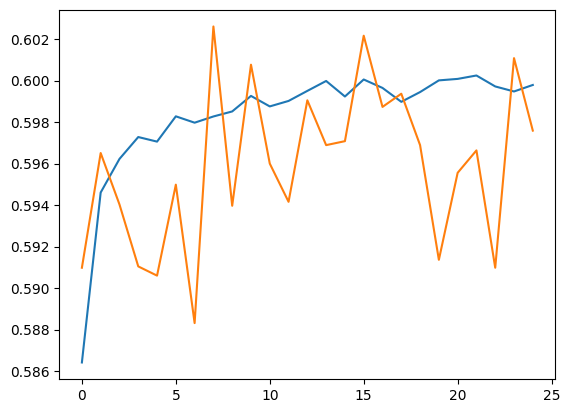

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [11]:
train_eval_result = model.evaluate(dict(train_df), train_df['Sentiment'])
validation_eval_result = model.evaluate(dict(validation_df), validation_df['Sentiment'])

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

   1/4385 ━━━━━━━━━━━━━━━━━━━━ 2:06 29ms/step - accuracy: 0.6875 - loss: 0.7365

  16/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6965 - loss: 0.7633  

  31/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7028 - loss: 0.7630

  46/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6979 - loss: 0.7782

  61/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6964 - loss: 0.7872

  76/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6952 - loss: 0.7929

  91/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6935 - loss: 0.7963

 106/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6919 - loss: 0.7992

 121/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6904 - loss: 0.8028

 136/4385 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6887 - loss: 0.8068

 151/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6867 - loss: 0.8115

 165/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6847 - loss: 0.8159

 180/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6829 - loss: 0.8202

 194/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6813 - loss: 0.8237

 209/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6799 - loss: 0.8271

 224/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6784 - loss: 0.8301

 239/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6770 - loss: 0.8333

 253/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6758 - loss: 0.8359

 268/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6747 - loss: 0.8384

 283/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6736 - loss: 0.8408

 298/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6727 - loss: 0.8429

 313/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6718 - loss: 0.8449

 328/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6709 - loss: 0.8469

 343/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6700 - loss: 0.8489

 358/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6691 - loss: 0.8507

 373/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6683 - loss: 0.8525

 388/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6675 - loss: 0.8542

 403/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6668 - loss: 0.8556

 418/4385 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6662 - loss: 0.8569

 433/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6656 - loss: 0.8582

 448/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6650 - loss: 0.8595

 463/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6644 - loss: 0.8607

 478/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6638 - loss: 0.8618

 493/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6633 - loss: 0.8628

 507/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6628 - loss: 0.8638

 522/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6624 - loss: 0.8648

 536/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6619 - loss: 0.8657

 551/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6615 - loss: 0.8667

 566/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6610 - loss: 0.8677

 581/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6606 - loss: 0.8686

 596/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6602 - loss: 0.8696

 611/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6598 - loss: 0.8704

 626/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6594 - loss: 0.8712

 641/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6591 - loss: 0.8720

 656/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6587 - loss: 0.8728

 671/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6583 - loss: 0.8736

 686/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6579 - loss: 0.8744

 701/4385 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6575 - loss: 0.8751

 716/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6572 - loss: 0.8759

 731/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6568 - loss: 0.8767

 746/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6565 - loss: 0.8774

 761/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6561 - loss: 0.8781

 776/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6557 - loss: 0.8788

 791/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6554 - loss: 0.8795

 806/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6550 - loss: 0.8802

 821/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6547 - loss: 0.8808

 836/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6544 - loss: 0.8815

 851/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6540 - loss: 0.8821

 866/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6537 - loss: 0.8828

 881/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6534 - loss: 0.8834

 896/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6530 - loss: 0.8841

 911/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6527 - loss: 0.8848

 926/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6523 - loss: 0.8855

 941/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6520 - loss: 0.8862

 956/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6516 - loss: 0.8868

 970/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6513 - loss: 0.8875

 984/4385 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6510 - loss: 0.8881

 999/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6506 - loss: 0.8888

1014/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6503 - loss: 0.8894

1029/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6499 - loss: 0.8901

1044/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6496 - loss: 0.8907

1059/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6493 - loss: 0.8914

1074/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6490 - loss: 0.8920

1089/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6487 - loss: 0.8926

1104/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6483 - loss: 0.8932

1119/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6480 - loss: 0.8938

1134/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6477 - loss: 0.8944

1149/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6474 - loss: 0.8950

1164/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6471 - loss: 0.8956

1179/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6469 - loss: 0.8961

1194/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6466 - loss: 0.8967

1209/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6463 - loss: 0.8972

1224/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6461 - loss: 0.8977

1239/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6458 - loss: 0.8983

1254/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6456 - loss: 0.8988

1269/4385 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6453 - loss: 0.8993

1284/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6451 - loss: 0.8997

1299/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6448 - loss: 0.9002

1314/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6446 - loss: 0.9007

1329/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6444 - loss: 0.9012

1344/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6441 - loss: 0.9017

1359/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6439 - loss: 0.9021

1374/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6437 - loss: 0.9026

1389/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6435 - loss: 0.9030

1404/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6432 - loss: 0.9035

1419/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6430 - loss: 0.9039

1434/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6428 - loss: 0.9043

1449/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6426 - loss: 0.9047

1464/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6424 - loss: 0.9051

1479/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6422 - loss: 0.9056

1494/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6420 - loss: 0.9060

1509/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6418 - loss: 0.9064

1524/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6416 - loss: 0.9068

1539/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6414 - loss: 0.9072

1554/4385 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6412 - loss: 0.9075

1569/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6410 - loss: 0.9079 

1584/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6408 - loss: 0.9083

1599/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6406 - loss: 0.9087

1614/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6404 - loss: 0.9090

1629/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6402 - loss: 0.9094

1644/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6401 - loss: 0.9098

1658/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6399 - loss: 0.9101

1673/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6397 - loss: 0.9105

1688/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6395 - loss: 0.9108

1703/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6393 - loss: 0.9112

1718/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6392 - loss: 0.9115

1733/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6390 - loss: 0.9119

1748/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6388 - loss: 0.9122

1763/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6386 - loss: 0.9126

1778/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6385 - loss: 0.9129

1793/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6383 - loss: 0.9133

1808/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6381 - loss: 0.9136

1823/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6379 - loss: 0.9139

1838/4385 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6378 - loss: 0.9143

1853/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6376 - loss: 0.9146

1868/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6374 - loss: 0.9149

1883/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6373 - loss: 0.9152

1898/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6371 - loss: 0.9155

1913/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6370 - loss: 0.9159

1928/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6368 - loss: 0.9162

1943/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6367 - loss: 0.9165

1958/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6365 - loss: 0.9167

1973/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6364 - loss: 0.9170

1988/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6362 - loss: 0.9173

2003/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6361 - loss: 0.9176

2018/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6359 - loss: 0.9179

2033/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6358 - loss: 0.9182

2048/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6356 - loss: 0.9184

2063/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6355 - loss: 0.9187

2078/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6353 - loss: 0.9190

2093/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6352 - loss: 0.9193

2108/4385 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6350 - loss: 0.9196

2123/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6349 - loss: 0.9199

2138/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6347 - loss: 0.9202

2152/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6346 - loss: 0.9204

2167/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6345 - loss: 0.9207

2181/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6343 - loss: 0.9210

2196/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6342 - loss: 0.9213

2211/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6340 - loss: 0.9215

2226/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6339 - loss: 0.9218

2241/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6338 - loss: 0.9221

2256/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6336 - loss: 0.9223

2271/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6335 - loss: 0.9226

2286/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6333 - loss: 0.9229

2301/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6332 - loss: 0.9231

2316/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6331 - loss: 0.9234

2331/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6329 - loss: 0.9236

2346/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6328 - loss: 0.9239

2361/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6327 - loss: 0.9241

2376/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6326 - loss: 0.9244

2391/4385 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6324 - loss: 0.9246

2406/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6323 - loss: 0.9249

2421/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6322 - loss: 0.9251

2435/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6321 - loss: 0.9253

2450/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6320 - loss: 0.9256

2465/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6318 - loss: 0.9258

2480/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6317 - loss: 0.9260

2494/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6316 - loss: 0.9262

2509/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6315 - loss: 0.9265

2524/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6314 - loss: 0.9267

2539/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6313 - loss: 0.9269

2554/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6312 - loss: 0.9271

2569/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6311 - loss: 0.9273

2584/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6310 - loss: 0.9275

2599/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6309 - loss: 0.9277

2614/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6308 - loss: 0.9280

2629/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6307 - loss: 0.9282

2644/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6305 - loss: 0.9284

2659/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6304 - loss: 0.9286

2674/4385 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6303 - loss: 0.9288

2689/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6302 - loss: 0.9290

2704/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6301 - loss: 0.9292

2719/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6300 - loss: 0.9294

2734/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6299 - loss: 0.9296

2749/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6298 - loss: 0.9298

2764/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6297 - loss: 0.9300

2779/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6296 - loss: 0.9301

2794/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6295 - loss: 0.9303

2809/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6294 - loss: 0.9305

2824/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6293 - loss: 0.9307

2839/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6292 - loss: 0.9309

2854/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6291 - loss: 0.9311

2869/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6290 - loss: 0.9313

2884/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6289 - loss: 0.9315

2899/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6288 - loss: 0.9316

2914/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6287 - loss: 0.9318

2929/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6286 - loss: 0.9320

2944/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6285 - loss: 0.9322

2959/4385 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6285 - loss: 0.9324

2974/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6284 - loss: 0.9325

2989/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6283 - loss: 0.9327

3004/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6282 - loss: 0.9329

3019/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6281 - loss: 0.9331

3034/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6280 - loss: 0.9332

3049/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6279 - loss: 0.9334

3063/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6278 - loss: 0.9336

3078/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6278 - loss: 0.9337

3093/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6277 - loss: 0.9339

3108/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6276 - loss: 0.9341

3123/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6275 - loss: 0.9342

3138/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6274 - loss: 0.9344

3153/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6273 - loss: 0.9346

3168/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6272 - loss: 0.9347

3183/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6271 - loss: 0.9349

3198/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6271 - loss: 0.9351

3213/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6270 - loss: 0.9352

3228/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6269 - loss: 0.9354

3243/4385 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6268 - loss: 0.9355

3258/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6267 - loss: 0.9357

3273/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6266 - loss: 0.9359

3288/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6265 - loss: 0.9360

3303/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6265 - loss: 0.9362

3318/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6264 - loss: 0.9364

3333/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6263 - loss: 0.9365

3348/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6262 - loss: 0.9367

3363/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6261 - loss: 0.9368

3378/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6260 - loss: 0.9370

3393/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6259 - loss: 0.9372

3408/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6259 - loss: 0.9373

3423/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6258 - loss: 0.9375

3438/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6257 - loss: 0.9376

3453/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6256 - loss: 0.9378

3468/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6255 - loss: 0.9379

3483/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6255 - loss: 0.9381

3498/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6254 - loss: 0.9382

3513/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6253 - loss: 0.9384

3528/4385 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6252 - loss: 0.9385

3543/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6251 - loss: 0.9387

3558/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6251 - loss: 0.9389

3573/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6250 - loss: 0.9390

3588/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6249 - loss: 0.9392

3603/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6248 - loss: 0.9393

3618/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6247 - loss: 0.9395

3633/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6247 - loss: 0.9396

3648/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6246 - loss: 0.9398

3663/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6245 - loss: 0.9399

3678/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6244 - loss: 0.9401

3693/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6244 - loss: 0.9402

3708/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6243 - loss: 0.9404

3722/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6242 - loss: 0.9405

3737/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6241 - loss: 0.9406

3752/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6241 - loss: 0.9408

3767/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6240 - loss: 0.9409

3782/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6239 - loss: 0.9411

3796/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6238 - loss: 0.9412

3811/4385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6238 - loss: 0.9413

3826/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6237 - loss: 0.9415

3840/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6236 - loss: 0.9416

3855/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6236 - loss: 0.9417

3869/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6235 - loss: 0.9419

3883/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6234 - loss: 0.9420

3898/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6234 - loss: 0.9421

3913/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6233 - loss: 0.9423

3928/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6232 - loss: 0.9424

3943/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6231 - loss: 0.9425

3957/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6231 - loss: 0.9427

3971/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6230 - loss: 0.9428

3986/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6229 - loss: 0.9429

4001/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6229 - loss: 0.9431

4016/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6228 - loss: 0.9432

4031/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6227 - loss: 0.9433

4046/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6227 - loss: 0.9435

4061/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6226 - loss: 0.9436

4076/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6225 - loss: 0.9437

4090/4385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6225 - loss: 0.9439

4105/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6224 - loss: 0.9440

4120/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6223 - loss: 0.9441

4135/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6223 - loss: 0.9442

4149/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6222 - loss: 0.9444

4163/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6221 - loss: 0.9445

4178/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6221 - loss: 0.9446

4193/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6220 - loss: 0.9447

4208/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6219 - loss: 0.9449

4223/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6219 - loss: 0.9450

4238/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6218 - loss: 0.9451

4253/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6217 - loss: 0.9452

4268/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6217 - loss: 0.9454

4283/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6216 - loss: 0.9455

4297/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6216 - loss: 0.9456

4312/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6215 - loss: 0.9457

4327/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6214 - loss: 0.9459

4342/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6214 - loss: 0.9460

4357/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6213 - loss: 0.9461

4372/4385 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6212 - loss: 0.9462

4385/4385 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6212 - loss: 0.9463


  1/493 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6562 - loss: 0.9149

 42/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6256 - loss: 0.9391  

 85/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6254 - loss: 0.9370

126/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6257 - loss: 0.9335

167/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6244 - loss: 0.9344

210/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6220 - loss: 0.9386

253/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6195 - loss: 0.9428

296/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6172 - loss: 0.9460

339/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6154 - loss: 0.9488

380/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6138 - loss: 0.9508

422/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6125 - loss: 0.9528

463/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6114 - loss: 0.9547

493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6105 - loss: 0.9561


Training set accuracy: 0.6025798916816711
Validation set accuracy: 0.5975865125656128


## Confusion matrix

Another very interesting statistic, especially for multiclass problems, is the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix allows visualization of the proportion of correctly and incorrectly labelled examples. We can easily see how much our classifier is biased and whether the distribution of labels makes sense. Ideally the largest fraction of predictions should be distributed along the diagonal.

In [12]:
predictions = model.predict(dict(validation_df))
predictions = tf.argmax(predictions, axis=-1)
predictions

  1/493 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step

 35/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

 69/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

104/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

141/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

178/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

215/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

252/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

289/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

326/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

363/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

400/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

437/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

473/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

493/493 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<tf.Tensor: shape=(15745,), dtype=int64, numpy=array([1, 1, 2, ..., 2, 2, 2])>

In [13]:
cm = tf.math.confusion_matrix(validation_df['Sentiment'], predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(50.72222222222221, 0.5, 'True')

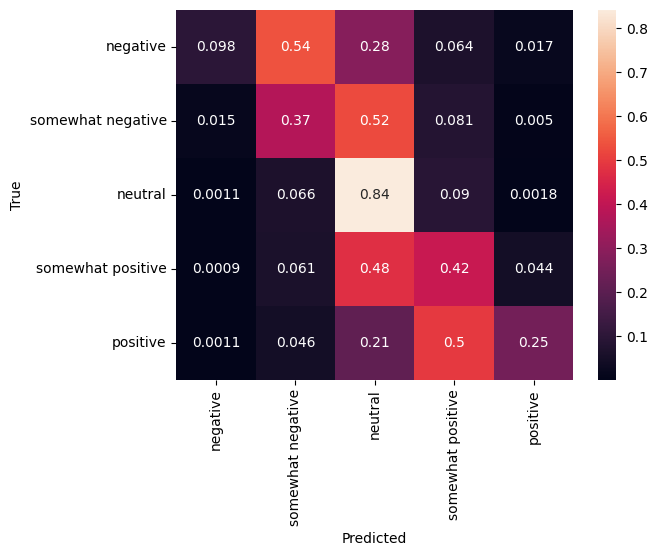

In [14]:
sns.heatmap(
    cm, annot=True,
    xticklabels=SENTIMENT_LABELS,
    yticklabels=SENTIMENT_LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

We can easily submit the predictions back to Kaggle by pasting the following code to a code cell and executing it:

``` python
test_predictions = model.predict(dict(test_df))
test_predictions = np.argmax(test_predictions, axis=-1)

result_df = test_df.copy()

result_df["Predictions"] = test_predictions

result_df.to_csv(
    "predictions.csv",
    columns=["Predictions"],
    header=["Sentiment"])
kaggle.api.competition_submit("predictions.csv", "Submitted from Colab",
                              "sentiment-analysis-on-movie-reviews")
```


After submitting, [check the leaderboard](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/leaderboard) to see how you did.